In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Tau Ceti will make a good proxy for late G stars. E140M data, will need to put it through STISfix.

In [2]:
star = 'tau_ceti'
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/{}/'.format(star)
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(x1dpath)), glob.glob('{}*sx1.fits'.format(x1dpath))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/oee504010_x1d.fits'],
      dtype='<U68')

In [3]:
# #echelle data
# #just found out= apparently not selecting the order sets all of the orders to data?
# for x in x1ds:
#     print(x)
#     hdr = fits.getheader(x, 0)
#     print(hdr['OPT_ELEM'])
#     nextend = hdr['NEXTEND']
#     print(nextend)
#     for i in range(nextend):
#         data = fits.getdata(x, i+1)
#         # print(data['A2Center'])
#         for dt in data:
#             w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
#             mask = w > 1160
#             w, f, e = w[mask], f[mask], e[mask]
#             plt.step(w, f, where='mid', c='C{}'.format(i))

#         # plt.step(w, e, where='mid', c='C1')
#         # plt.yscale('log')
#         # plt.xlim(1300, 1350)
#     # plt.ylim(-1e-13, 1e-13)
#     plt.xlim(1210, 1220)
#     plt.axhline(0, c='C2', alpha=0.5, ls='--')    
#     plt.show()


In [4]:
# for dt in data:
#         w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
#         mask = w > 1160
#         w, f, e = w[mask], f[mask], e[mask]
#         plt.step(w, f, where='mid')
#         plt.step(w, e, where='mid')
# plt.xlim(2790, 2810)

In [5]:
# import importlib
# import stis_echelle_splice as stisfix
# importlib.reload(stisfix)


need to modify echelle splice for more than one data array -done I think

In [6]:
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/oee504010_x1d.fits'],
      dtype='<U68')

In [7]:
# stisfix.splice(filepath = path+'nuv/', outpath = 'misc_data/tau_ceti_spliced/', nclip=17)

misc_data/tau_ceti_spliced/oee504010_spliced.fits
E230H
22493
1


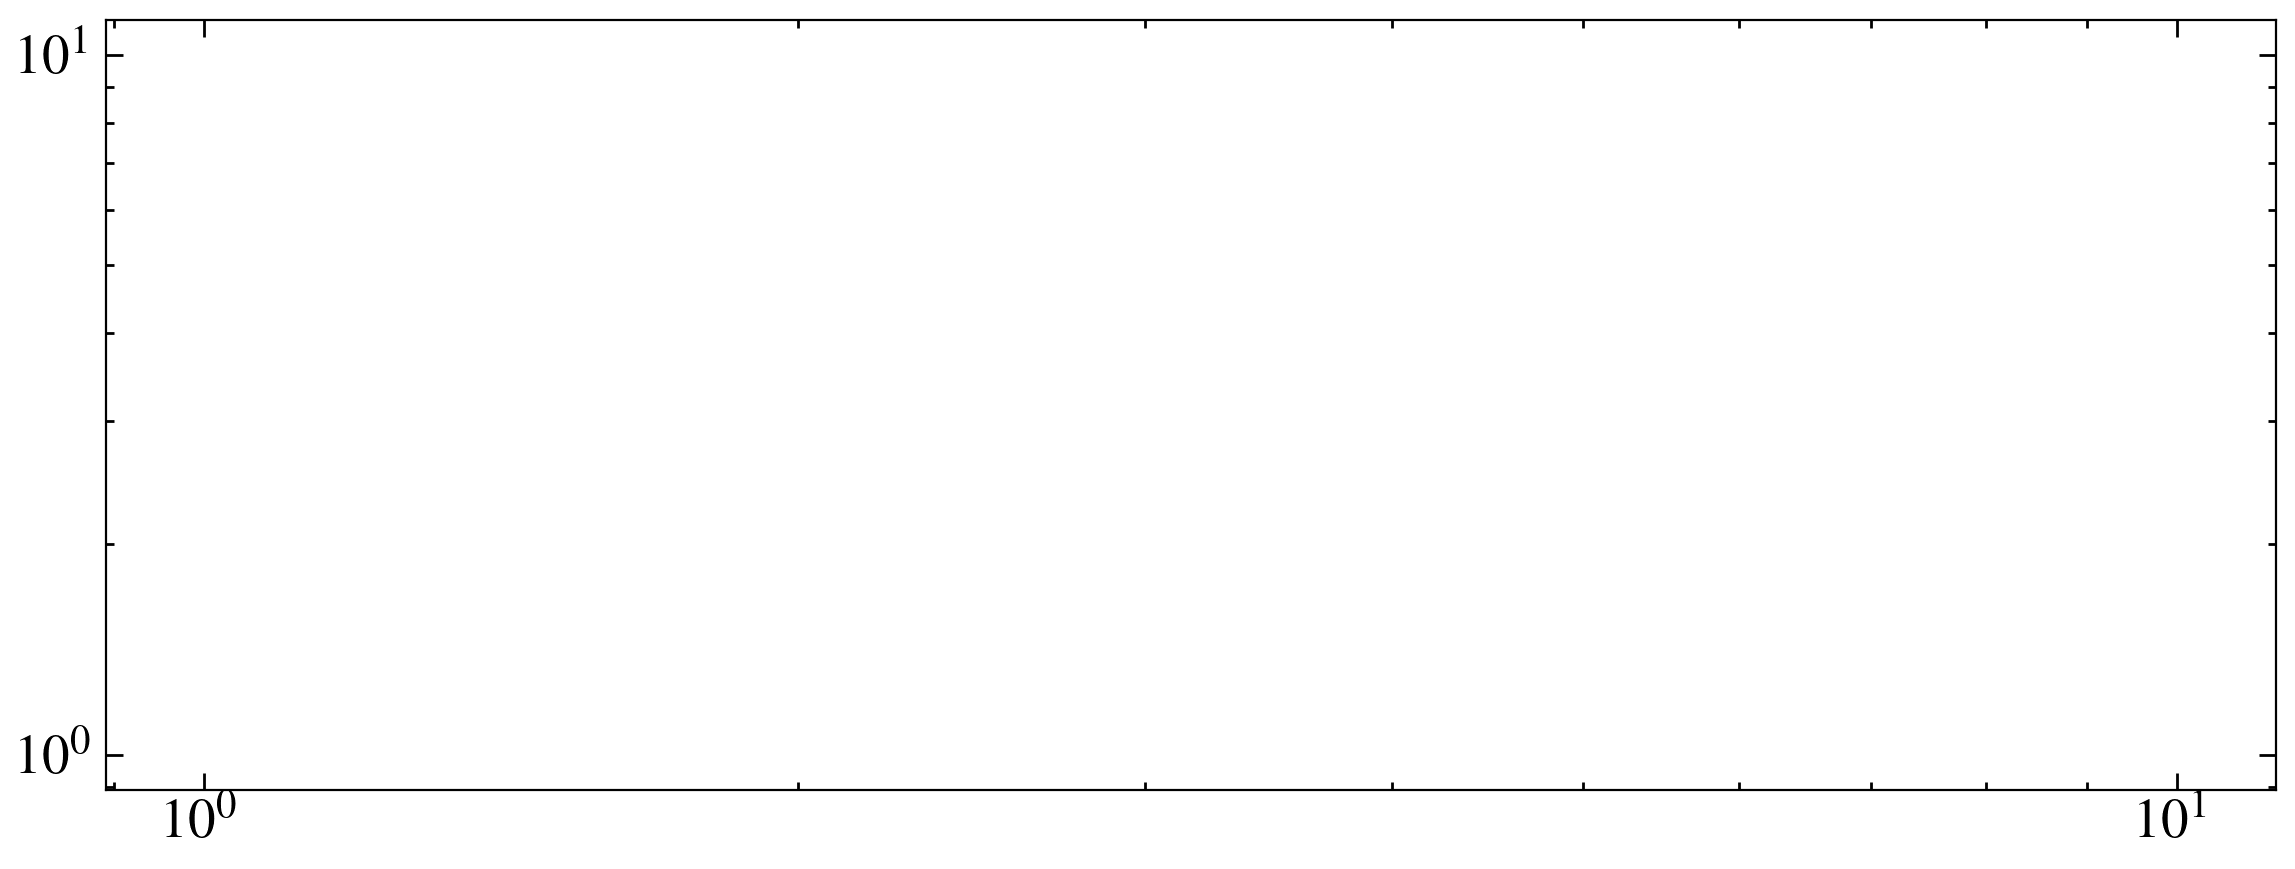

In [66]:
spliced_x1ds = glob.glob('misc_data/tau_ceti_spliced/*spliced.fits')

for x in spliced_x1ds[-1:]:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    # print(data['A2Center'])
   
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    print(len(f))
    print(len(f[f < 0]))
    mask = (w > 1160) #& (f >0)
    w, f, e = w[mask], f[mask], e[mask]
#     plt.step(w, f, where='mid')
    # plt.step(w, e, where='mid', c='C1')
    
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1300, 1350)
# plt.ylim(1e-12)
# plt.show()

In [67]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux,error

In [10]:
demlines = Table.read('DEM_goodlinelist .csv')
demlines.dtype.names

('Ion', 'Wavelength', 'Likelihood to measure', 'Log Formation Temperature')

(1150.0, 1720.0)

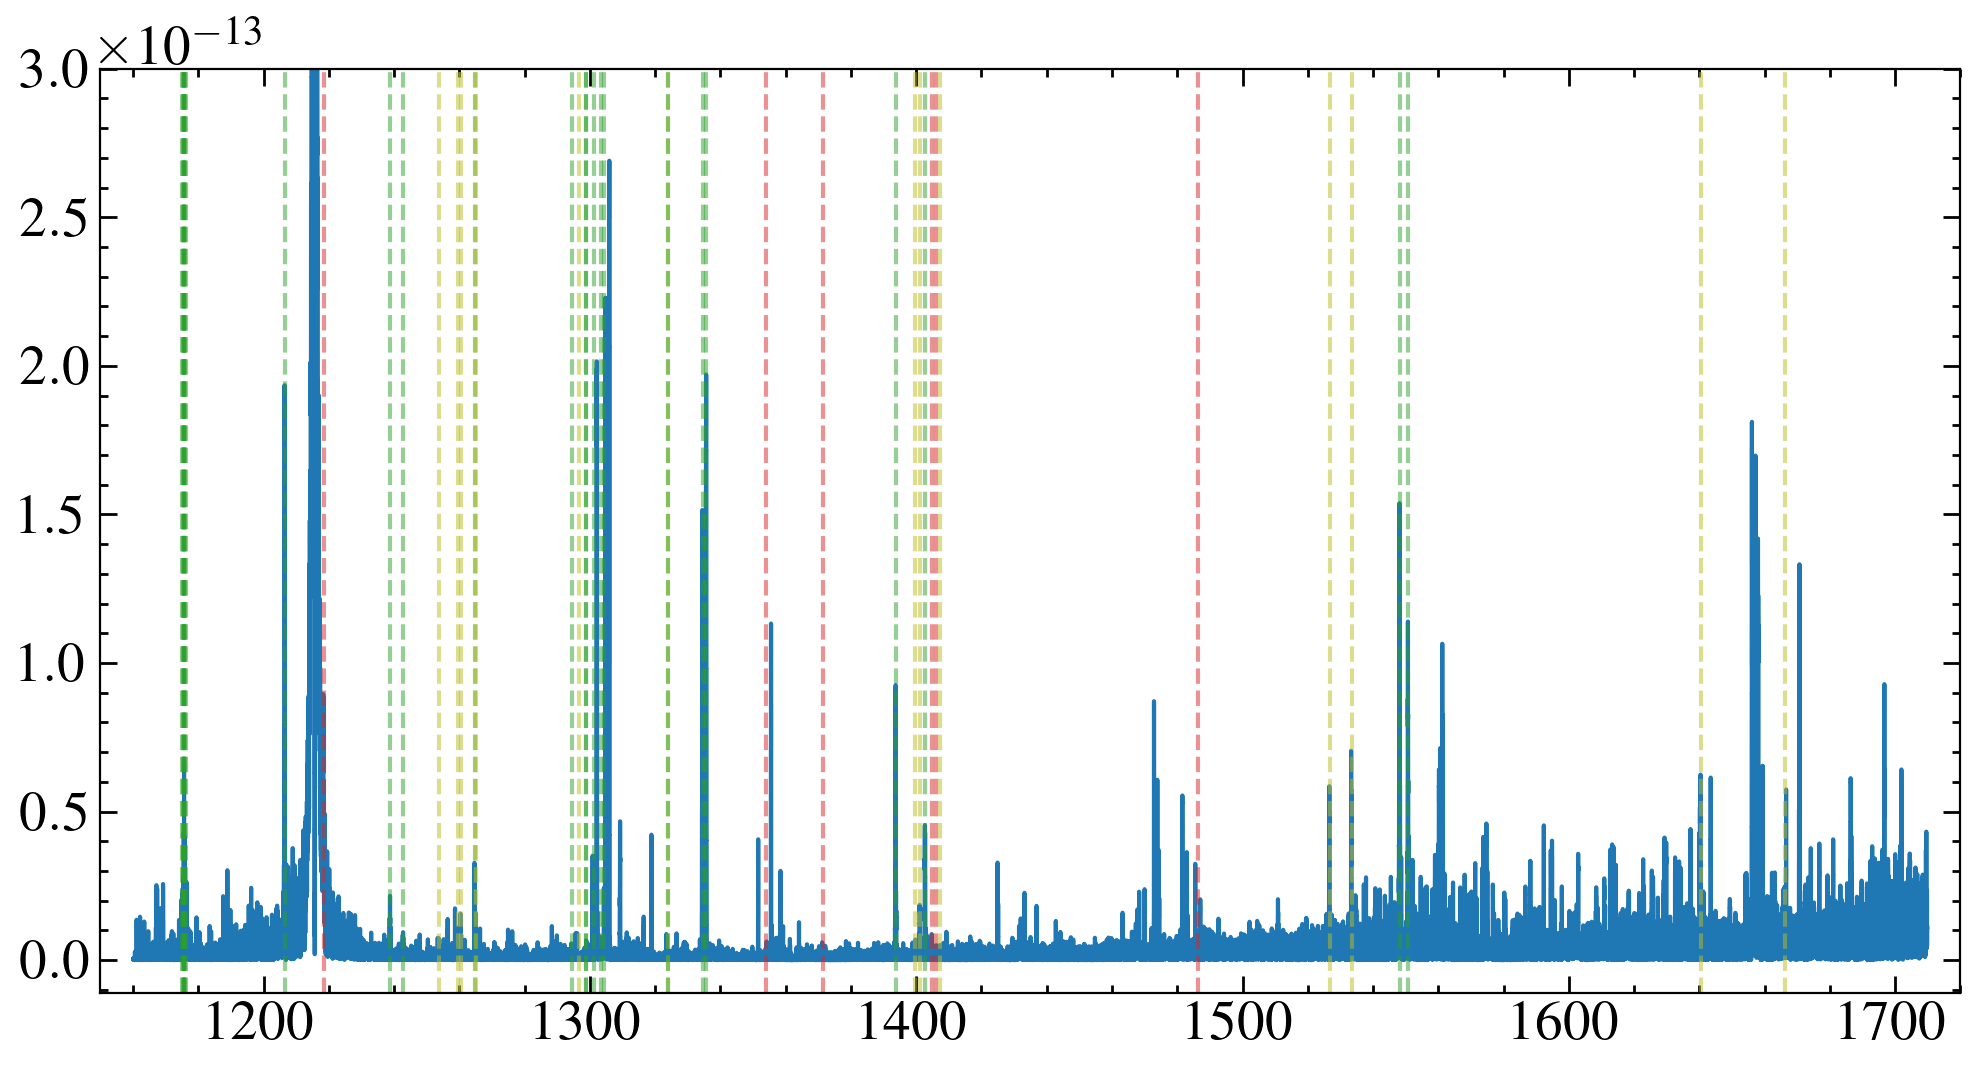

In [68]:
w_fuv = []
f_fuv = []
e_fuv = []
roots = []
n=0
for x in spliced_x1ds:
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'E140M':
        roots.append(fits.getheader(x, 0)['ROOTNAME'])
        mask = (w > 1160)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        n +=1
    if grating == 'E230H':
        mask = (w > 1700) & (w <3130)
        w_nuv, f_nuv, e_nuv = w[mask], f[mask], e[mask]
    if grating == 'G430L':
        mask = (w > 3000) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]


        
        
f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)
mask = (f_fuv > 0)
w_fuv, f_fuv, e_fuv = w_fuv[mask], f_fuv[mask], e_fuv[mask]


plt.figure(figsize=(12, 6))

plt.step(w_fuv, f_fuv, where='mid', label='E140M')
plt.ylim(-0.11e-13, 3e-13)

for i, line in enumerate(demlines['Wavelength']):
    c= 'C2'
    if demlines['Likelihood to measure'][i] == 'Medium':
        c = 'C8'
    if demlines['Likelihood to measure'][i] == 'Low':
        c = 'C3'
    plt.axvline(line, c = c, ls='--', alpha=0.5)

plt.xlim(1150, 1720)
# plt.step(w_fuv, e_fuv, where='mid')
# plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# plt.xscale('log')
# plt.yscale('log')

In [12]:
# plt.step(w_fuv, e_fuv, where='mid')
# plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1e-17)

Lya line from BW.

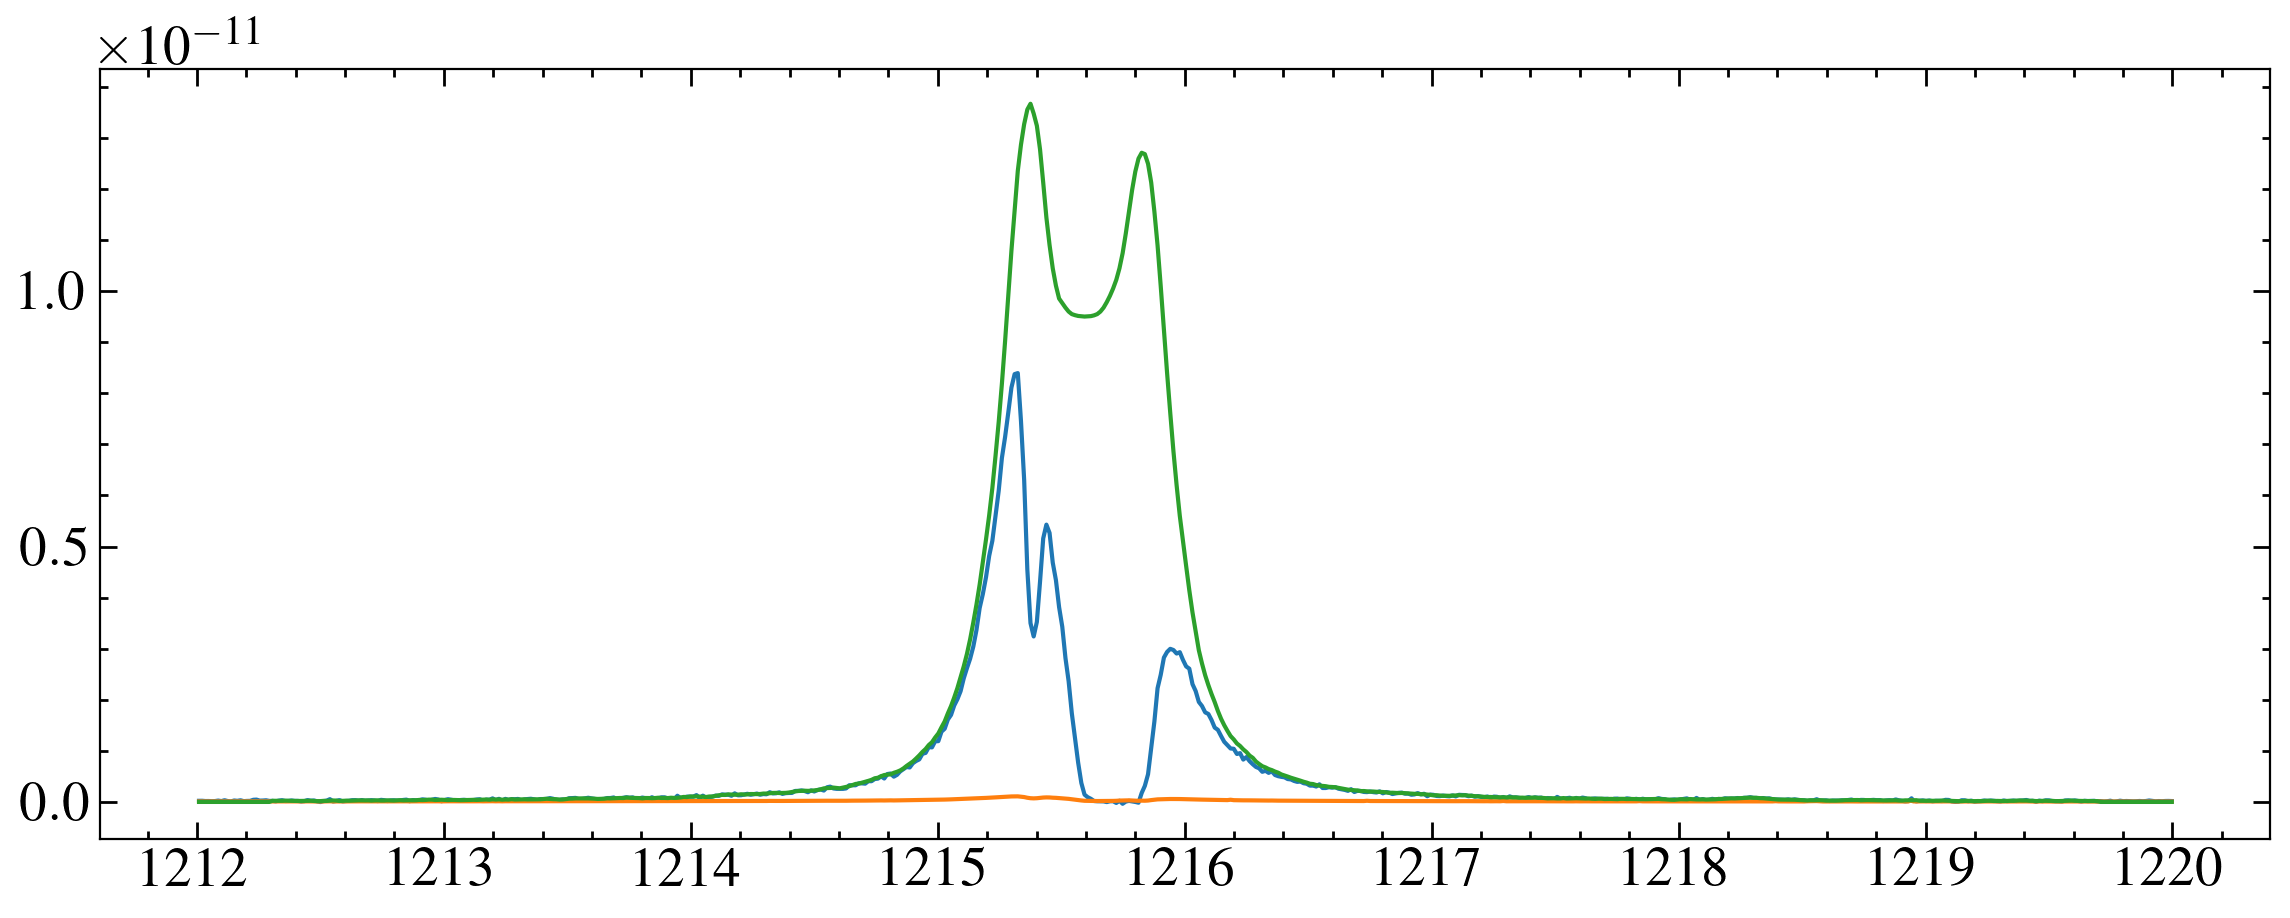

/tmp/ipykernel_3615/4023125462.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(lyaw[lyamask], (lyaf/lyamod)[lyamask])


8.3965612e-12


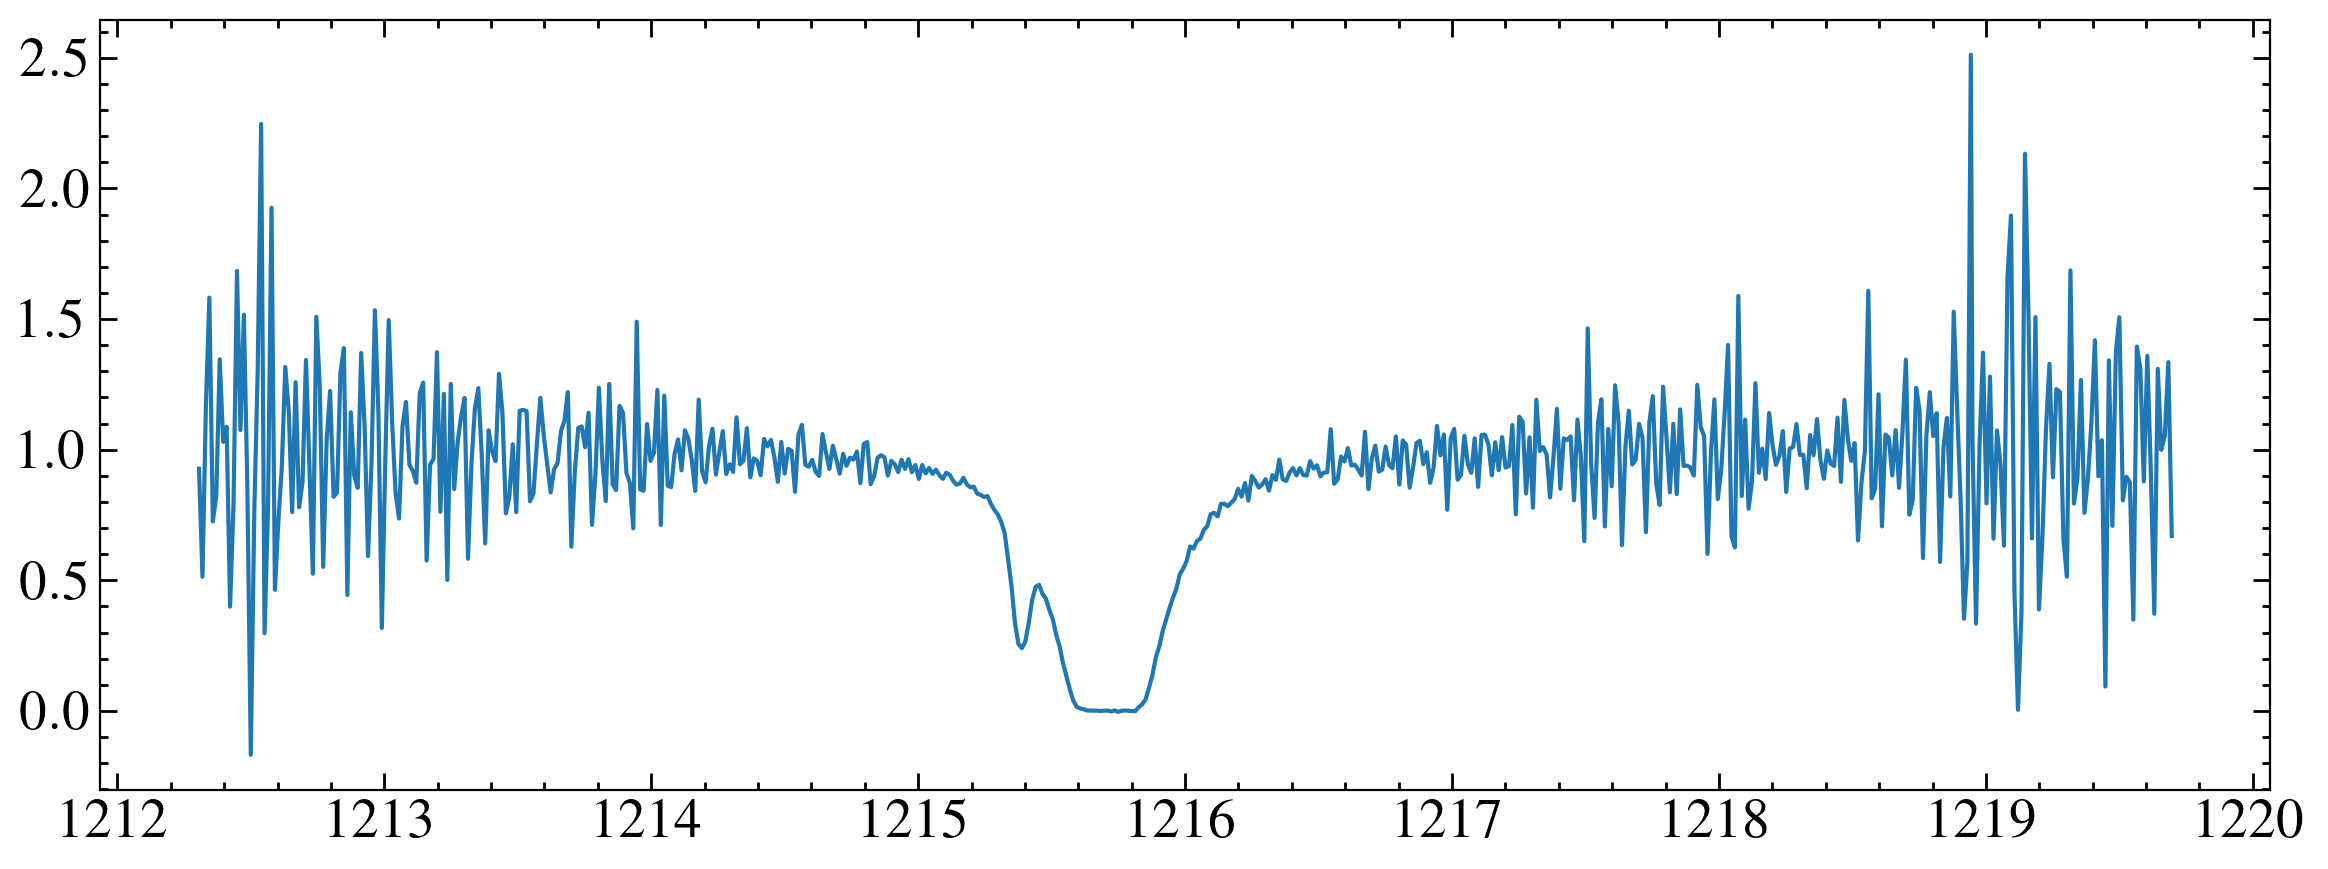

In [13]:
lyapath =  '/media/david/2tb_ext_hd/hddata/meats/lya/tau_ceti/taucet_lya.txt'
lyaw, lyaf, lyae, lyamod = np.loadtxt(lyapath, unpack =True)
plt.plot(lyaw, lyaf)
plt.plot(lyaw, lyae)
plt.plot(lyaw, lyamod)

plt.show()
lyamask = (lyamod > 0.0)
plt.plot(lyaw[lyamask], (lyaf/lyamod)[lyamask])
print(np.max(lyaf))

In [14]:
# plt.step(w_fuv, f_fuv, where='mid')
# plt.plot(lyaw, lyamod)
# plt.yscale('log')
# # plt.plot(lyaw, lyaf)

# # plt.xlim(1210, 1220)

In [15]:
# plt.plot(lyaw, lyamod)
# plt.ylim(-1e-12, 1e-12)
# plt.axhline(0, ls='--', c='C1')

In [16]:
#params from TICv8 via exoplanet archive
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.92
teff = 5333
teff_e = np.mean([123.7510, 74.6878])

radius = 0.8330490
distance = 3.60304

save_path = 'models/'
star = 'Tau_Ceti'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.56051
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/Tau_Ceti_phoenix_interpolated.ecsv')
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [17]:
# pmask = (pw > 1700) & (pw < 100000)
# pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = pp.smear(pwi, pfi, 500)
# plt.plot(pwi, pfi)

In [18]:
# pmask = (pw > 1000) & (pw < 200000)
# pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = pp.smear(pwi, pfi, 500)

# plt.plot(pwi, pfi)

# plt.step(w_fuv, e_fuv, where='mid', zorder=-1)
# plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# plt.plot(lyaw, lyamod)

# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1e-17)

X-rays? Swift gives some results. XMM better? Also a bunch of IUE data, if I can remember how to open it...need to do some echelle splicing.

In [19]:
# iuepath = '/media/david/2tb_ext_hd/hddata/meats/iue/tau_ceti/'
# # swfiles = glob.glob('{}sw*/*.fits'.format(iuepath))

# # for sw in swfiles:
# #     data = fits.getdata(sw, 1)[0]
# #     plt.plot(data['Wave'], data['Flux'])

# # useful stuff is in the lw files

# testdat = fits.getdata('{}lwr02625/lwr02625.mxhi'.format(iuepath), 1)
# for dt in testdat:
#     w0 = dt['WAVELENGTH']
#     dw = dt['DELTAW']
#     flux = dt['ABS_CAL']
#     w = np.full(len(flux), w0)
#     for i in range(len(flux)):
#         w[i] = w[i] +dw*i
#     plt.step(w, flux, where='mid')
# # plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)

# plt.yscale('log')

In [20]:
# pmask = (pw > 2500) & (pw < 2900)
# pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = pp.smear(pwi, pfi, 228000)

# plt.plot(pwi, pfi)

# # plt.step(w_fuv, e_fuv, where='mid', zorder=-1)
# plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# # plt.plot(lyaw, lyamod)

# # plt.xscale('log')
# # plt.yscale('log')
# # plt.ylim(1e-17)
# # plt.xlim(w_nuv[0], w_nuv[-1])
# plt.ylim(0, 3e-11)
# plt.xlim(2780, 2830)

In [21]:
import importlib
import prepare_stis


Make HLSP

In [22]:
# path

In [23]:
importlib.reload(prepare_stis)
savepath = 'draft_hlsp/tau_ceti/'
hlsp = 'meats_hlsp_info.csv'
version = 1
star = 'Tau_Ceti'
# prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath=savepath, plot=True, save_ecsv=False, save_fits=True, star=star, nclip=5)

Gaussian
[-13.99845858 -13.40106397] km / s
-13.699761272802611 km / s
Voigt
-14.065935527116062 km / s 0.6343991793473069
4.077622486248114e-14
3.745006338087722e-14 6.038534057279506e-16
2.1446562280572486e-14
1.8043048206372142e-14 6.557624373356559e-16


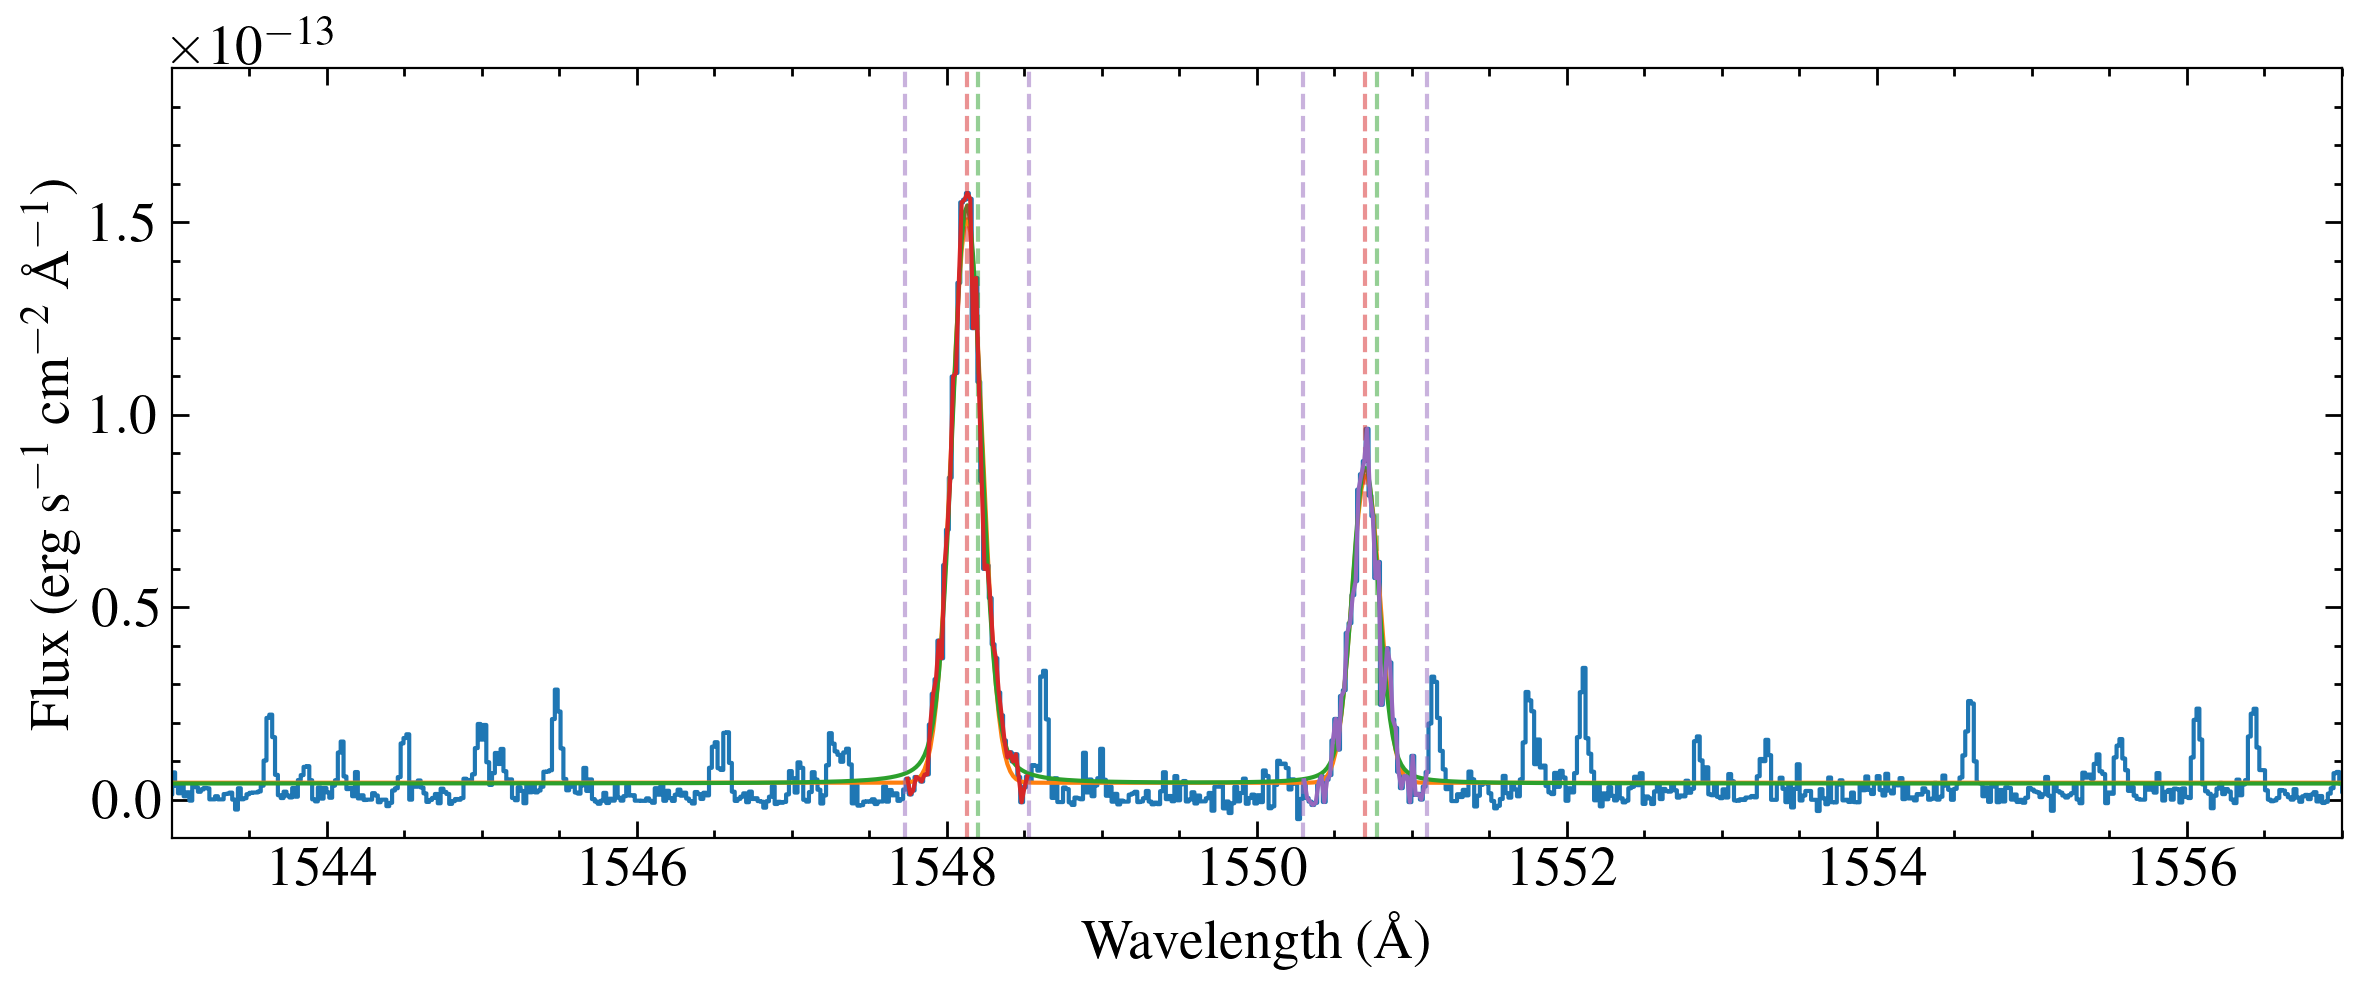

In [24]:
# import astropy.io.fits as fits
# import matplotlib.pyplot as plt
fitter = fitting.LevMarLSQFitter()

def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) 
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) 
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1


data = fits.getdata('draft_hlsp/tau_ceti/hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits')
w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = (w > 1540) & (w < 1560)
w, f, e = w[mask], f[mask], e[mask]
plt.step(w, f, where='mid')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

lines = [1548.201,1550.772]


[plt.axvline(line, c = 'C2', ls='--', alpha=0.5) for line in lines]

gg_init = models.Gaussian1D(2e-13, lines[0], 0.1)+models.Gaussian1D(2e-13, lines[1], 0.1)+models.Const1D(0)
v_init = models.Voigt1D(x_0=lines[0], amplitude_L=2e-13, fwhm_L=0.1, fwhm_G=0.1)+ \
models.Voigt1D(x_0=lines[1], amplitude_L=2e-13, fwhm_L=0.1, fwhm_G=0.1)+models.Const1D(0)#, fixed = dict(amplitude=True))

def tiedfunc1(mod):
        x_0 = mod.x_0_0.value+np.diff(lines)
        # fwhm_G = mod.fwhm_G_1.value
        return x_0
    
v_init.x_0_1.tied=tiedfunc1
        
gg_fit = fitter(gg_init, w, f, maxiter=100000)
v_fit = fitter(v_init, w, f, maxiter=100000)
v_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
# print(gg_fit)
# print(v_fit)
# print(v_fit_e)

print('Gaussian')
obs_lam = np.array([gg_fit[0].mean.value, gg_fit[1].mean.value])
dv = (obs_lam*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines*u.AA))
print(dv)
print(np.mean(dv))


print('Voigt')
# obs_lam = np.array([v_fit[0].x_0.value, v_fit[1].x_0.value])
# print(np.diff(obs_lam), np.diff(lines))
obs_lam = v_fit[0].x_0.value
dv = (obs_lam*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[0]*u.AA))

dv_e =  np.mean([abs(dv.value -((obs_lam+v_fit_e[0])*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[0]*u.AA)).value),
                abs(dv.value -((obs_lam-v_fit_e[0])*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lines[0]*u.AA)).value)])

print(dv, dv_e)


# print(np.mean(dv))

plt.plot(w, gg_fit(w))    
plt.plot(w, v_fit(w))    

line_width = 0.4
for line in lines:
    obs_line = dv.to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
    plt.axvline(obs_line, c='C3', ls='--', alpha=0.5)
    plt.axvline(obs_line+line_width, c='C4', ls='--', alpha=0.5)
    plt.axvline(obs_line-line_width, c='C4', ls='--', alpha=0.5)
    line_mask = (w > obs_line-line_width) & (w < obs_line+line_width)
    line_w, line_f, line_e = w[line_mask], f[line_mask], e[line_mask]
    w0, w1 = wavelength_edges(line_w)
    # line_f = v_fit(line_w)
    plt.plot(line_w, line_f )
    # print(np.trapz(line_f, line_w))
    fi = np.sum(line_f*(w1-w0))
    ei = (np.sum(line_e**2 * (w1-w0)**2))**0.5
    ci = np.sum(v_fit[2](line_w)*(w1-w0))
    print(fi)
    fi = fi -ci
    print(fi, ei)
    # ei = (np.sum(e**2 * (w1-w0)**2))**0.5
    
    


plt.xlim(1543, 1557)
plt.ylim(-0.1e-13, 1.9e-13)
plt.show()

# print(v_fit)

In [25]:
# data = fits.getdata('draft_hlsp/tau_ceti/hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits')
# w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
# mask = (w > 1170) & (w < 1180)
# w, f, e = w[mask], f[mask], e[mask]
# plt.step(w, f, where='mid')

20230330 Looking at IUE data again, mix of high and low res

lwp02224
lwp04912
lwp15797
lwp15798


NameError: name 'w_nuv' is not defined

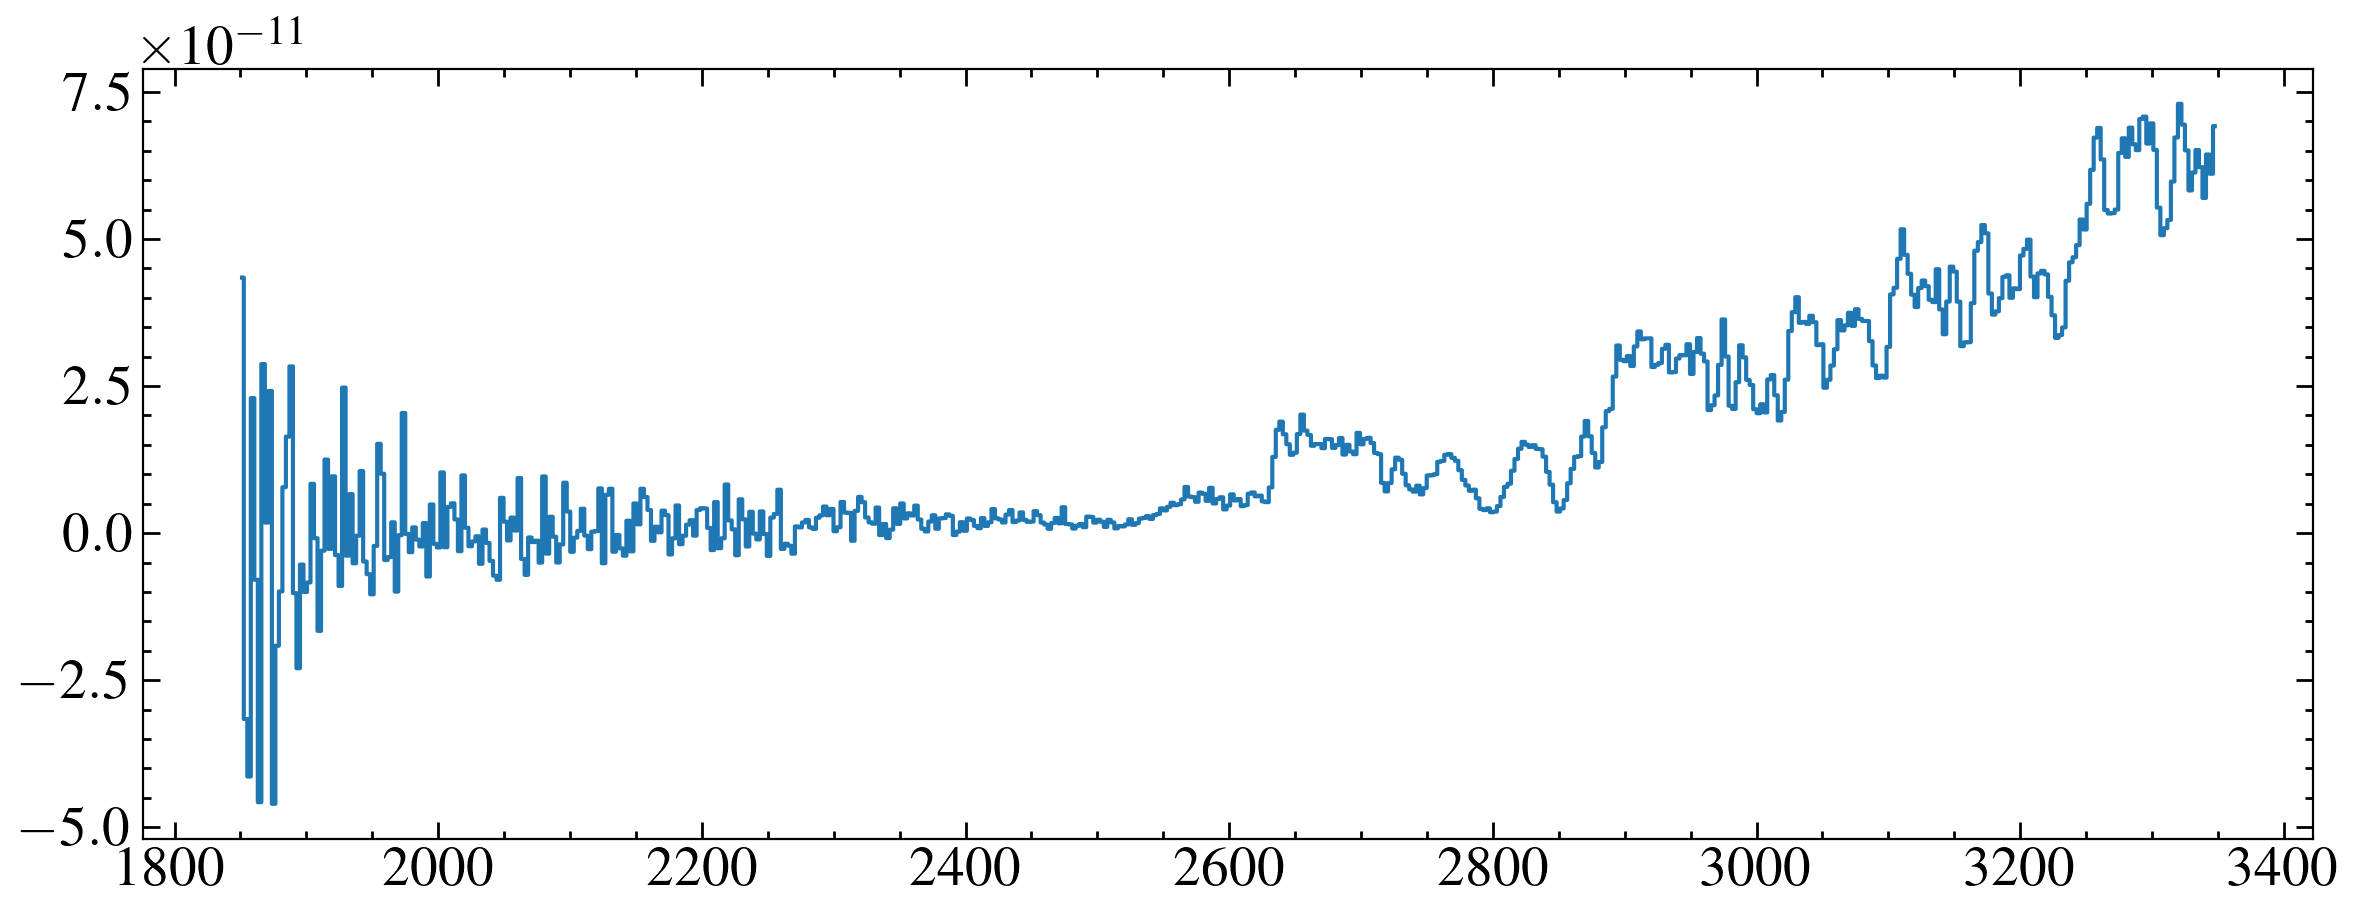

In [61]:
# iuepath = '/media/david/2tb_ext_hd/hddata/meats/iue/tau_ceti/'
# iuesets = os.listdir(iuepath)
# badspecs = ['lwp15797', 'lwp18288', 'lwp20753', 'lwp18262']

# for dataset in iuesets:
#     print(dataset)
#     vos= glob.glob('{}{}/*vo.fits'.format(iuepath, dataset))
#     if len(vos) > 0 and dataset not in badspecs:
#         data = fits.getdata(vos[0], 1)[0]
#         w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']
#         # plt.step(w[dq==0], f[dq==0], where='mid')
#         plt.step(w, f, where='mid')
#         # plt.step(w, e, where='mid')
#         plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
#         plt.step(w_fuv, f_fuv, where='mid', zorder=-1)
        
#         plt.yscale('log')
#         plt.show()



All low_res datasets look ok except for lwp18262. Ok no there's some flux call issue, check against stis. Higher flux cal is correct. Bad specs = lwp15797 lwp18288 lwp20753 lwp18262.

In [62]:
# fig, ax = plt.subplots()

# sw_f = []
# sw_e = []
# lw_f = []
# lw_e = []
# n = 0
# o = 0
# for dataset in iuesets:
#     # print(dataset)
#     vos= glob.glob('{}{}/*vo.fits'.format(iuepath, dataset))
#     if len(vos) > 0 and dataset not in badspecs:
#         spec = vos[0]
#         data = fits.getdata(spec, 1)[0]
#         w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']

#         if os.path.split(spec)[1][0:2] == 'sw':
#             if n == 0:
#                 w_sw = w
#                 sw_f.append(f)
#                 sw_e.append(e)
#             else:
#                 fi = interp1d(w, f, fill_value='extrapolate')(w_sw)
#                 ei = interp1d(w, e, fill_value='extrapolate')(w_sw)
#                 sw_f.append(fi)
#                 sw_e.append(ei)
#             n += 1
#         if os.path.split(spec)[1][0:2] == 'lw':
#             if o == 0:
#                 w_lw = w
#                 lw_f.append(f)
#                 lw_e.append(e)
#             else:
#                 fi = interp1d(w, f, fill_value='extrapolate')(w_lw)
#                 ei = interp1d(w, e, fill_value='extrapolate')(w_lw)
#                 lw_f.append(fi)
#                 lw_e.append(ei)
#             o += 1

# # print(lwr_e)
# f_lw, e_lw = spectra_adder(np.array(lw_f), np.array(lw_e))
# f_sw, e_sw = spectra_adder(np.array(sw_f), np.array(sw_e))


#         # ax.step(w[dq==0],f[dq==0], where='mid')
#         # ax.step(w,f, where='mid')

# smask = (f_sw > 0) & (w_sw < 1200) | (f_sw > 0) & (w_sw > 1230) 
# lmask = (f_lw > 0) & (w_lw >= w_sw[-1])

# f_sw = convolve(f_sw,Box1DKernel(2))
# f_lw = convolve(f_lw,Box1DKernel(2))
# # e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)

# norm = 1/f_lw[-1]

# ax.step(w_lw[lmask], f_lw[lmask], where='mid')
# # ax.step(w_lw, f_lw, where='mid')
# ax.step(w_sw[smask], f_sw[smask], where='mid')
# # ax.step(w_sw, f_sw, where='mid')

# ax.set_yscale('log')

High-res data is pretty bad, probably not worth it

In [28]:
# fig, ax = plt.subplots()

# ax.step(w_lw[lmask], f_lw[lmask], where='mid')
# ax.step(w_sw[smask], f_sw[smask], where='mid')

# ax.step(w_fuv, f_fuv, where='mid', zorder=-1)
# ax.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# ax.plot(lyaw, lyamod)

# ax.set_yscale('log')
# ax.set_xscale('log')

Well that's concerning, very different flux cal beteen IUE sw and E140M. All IUE spectra affected. Which is right? Oops helps if you plot flux not error...still a smidge high.

In [29]:
# fdata = fits.getdata('draft_hlsp/tau_ceti/hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits',1)
# w_fuv, f_fuv, e_fuv = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
# mask = w_fuv > 1160
# w_fuv, f_fuv, e_fuv = w_fuv[mask], f_fuv[mask], e_fuv[mask] 

In [30]:
# pmask = (pw > 1000) & (pw < 2000)
# pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = pp.smear(pwi, pfi, 500)



# fig, ax = plt.subplots()

# # ax.step(w_lw[lmask], f_lw[lmask], where='mid')
# ax.step(w_sw[smask], f_sw[smask], where='mid')
# # ax.step(w_sw[smask], e_sw[smask], where='mid')

# lymask = (w_fuv < 1200) | ((w_fuv > 1230))
# f_fuvi = convolve(f_fuv,Box1DKernel(2))

# ax.step(w_fuv[lymask], f_fuvi[lymask], where='mid', zorder=-1)


# wfi, ffi = pp.smear(w_fuv, f_fuv, 300)
# lymask = (wfi < 1200) | ((wfi > 1230))
# ax.step(wfi[lymask], ffi[lymask], where='mid', zorder=-1)
# ax.step(wfi[lymask], ffi[lymask]*3, where='mid', ls='--')
# # ax.step(pwi, pfi)uide star acquisition failed. Actual guide mode is gyro. COS internal shutter closed. No counts in exposure. Actual exposure time significantly less than planned exposure.



# # ax.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# # ax.plot(lyaw, lyamod)

# # ax.set_yscale('log')
# # ax.set_xscale('log')

In [31]:
# (max(w_sw) - min(w_sw))/6

No continummn detection in STIS - is there in IUE? Maybe scale to emission lines? NUV looks fine.

In [32]:
# fig, ax = plt.subplots()

# ax.step(w_lw[lmask], f_lw[lmask], where='mid')
# # ax.step(w_sw[smask], f_sw[smask], where='mid')

# # ax.step(w_fuv, f_fuv, where='mid', zorder=-1)


# wni, fni = pp.smear(w_nuv, f_nuv, 500)
# # print(np.trapz(f_nuv, w_nuv), np.trapz(fni, wni))
# # lmask = (wfi < 1200) | ((wfi > 1230))
# ax.step(wni, fni, where='mid', zorder=-1)
# pmask = (pw > 2000) & (pw < 3500)
# pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = pp.smear(pwi, pfi, 500)

# mgmask = (wni > 2780) & (wni < 2820)
# smg = np.trapz(fni[mgmask], wni[mgmask])


# mgmask = (w_lw > 2780) & (w_lw < 2820)
# img = np.trapz(f_lw[mgmask], w_lw[mgmask])
# print(img, smg, smg/img)

# [plt.axvline(line, ls='--', c='C1') for line in (2780, 2820)]

# # ax.step(pwi, pfi)
# # ax.set_yscale('log')

In [33]:
# pmask = (pw > 1000) & (pw < 2000)
# pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = pp.smear(pwi, pfi, 500)



# fig, ax = plt.subplots()

# # ax.step(w_lw[lmask], f_lw[lmask], where='mid')
# ax.step(w_sw[smask], f_sw[smask], where='mid')
# ax.step(w_sw[smask], e_sw[smask], where='mid')

# lymask = (w_fuv < 1200) | ((w_fuv > 1230))

# ax.step(w_fuv[lymask], f_fuv[lymask], where='mid', zorder=-1)


# wfi, ffi = pp.smear(w_fuv, f_fuv, 400)
# lymask = (wfi < 1200) | ((wfi > 1230))
# ax.step(wfi[lymask], ffi[lymask], where='mid', zorder=-1)
# ax.step(pwi, pfi)



# # ax.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# # ax.plot(lyaw, lyamod)

# ax.set_yscale('log')
# # ax.set_xscale('log')

In [34]:
# fig, ax = plt.subplots(figsize=(12,6))

# for dataset in iuesets:
#     # print(dataset)
#     vos= glob.glob('{}{}/*vo.fits'.format(iuepath, dataset))
#     if len(vos) > 0 and dataset not in badspecs:
#         spec = vos[0]
#         if os.path.split(spec)[1][0:2] == 'sw':

#             data = fits.getdata(spec, 1)[0]
#             w, f, e, dq = data['WAVE'], data['FLUX'], data['SIGMA'], data['QUALITY']
#             # plt.step(w[dq==0], f[dq==0], where='mid')
#             mask = (w > 1170) & (w < 1200) | (w > 1230)
#             f = convolve(f,Box1DKernel(2))
            
#             plt.step(w[mask], f[mask], where='mid', alpha =0.5, c='C0', label = 'IUE')
#             # plt.step(w[mask], e[mask], where='mid')
#             # plt.show()
            
# plt.step(wfi[lymask], ffi[lymask], where='mid', zorder=100, c='C1', lw=2, label = 'STIS to R(IUE) ')

# f_fuvi = convolve(f_fuv,Box1DKernel(2))


# ax.step(w_fuv[lymask], f_fuvi[lymask], where='mid', zorder=-1, c='C2', alpha =0.5, label='STIS')

#             # plt.step(w, e, where='mid')
#             # plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
    
#             # plt.step(w_fuv, f_fuv, where='mid', zorder=-1, alpha =0.5)

#             # plt.yscale('log')
#         # plt.show()
# handles, labels = fig.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), frameon=True, loc=1)

# ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# ax.set_xlabel('Wavelength (\AA)')

# ax.set_ylim(-0.2e-13, 2.6e-13)
# ax.set_xlim(1150, 1950)
# fig.tight_layout()

# fig.savefig('plots/tau_ceti_fuv.pdf')

Measure strong emission lines and compare.

[1298, 1312] 1.3660722865309368e-13
[1330, 1340] 7.561552112799363e-14
[1542, 1556] 1.1522143207131245e-13
[1556, 1565] 8.104449950958445e-14
[1650, 1665] 2.3062335377718996e-13


(1250.0, 1700.0)

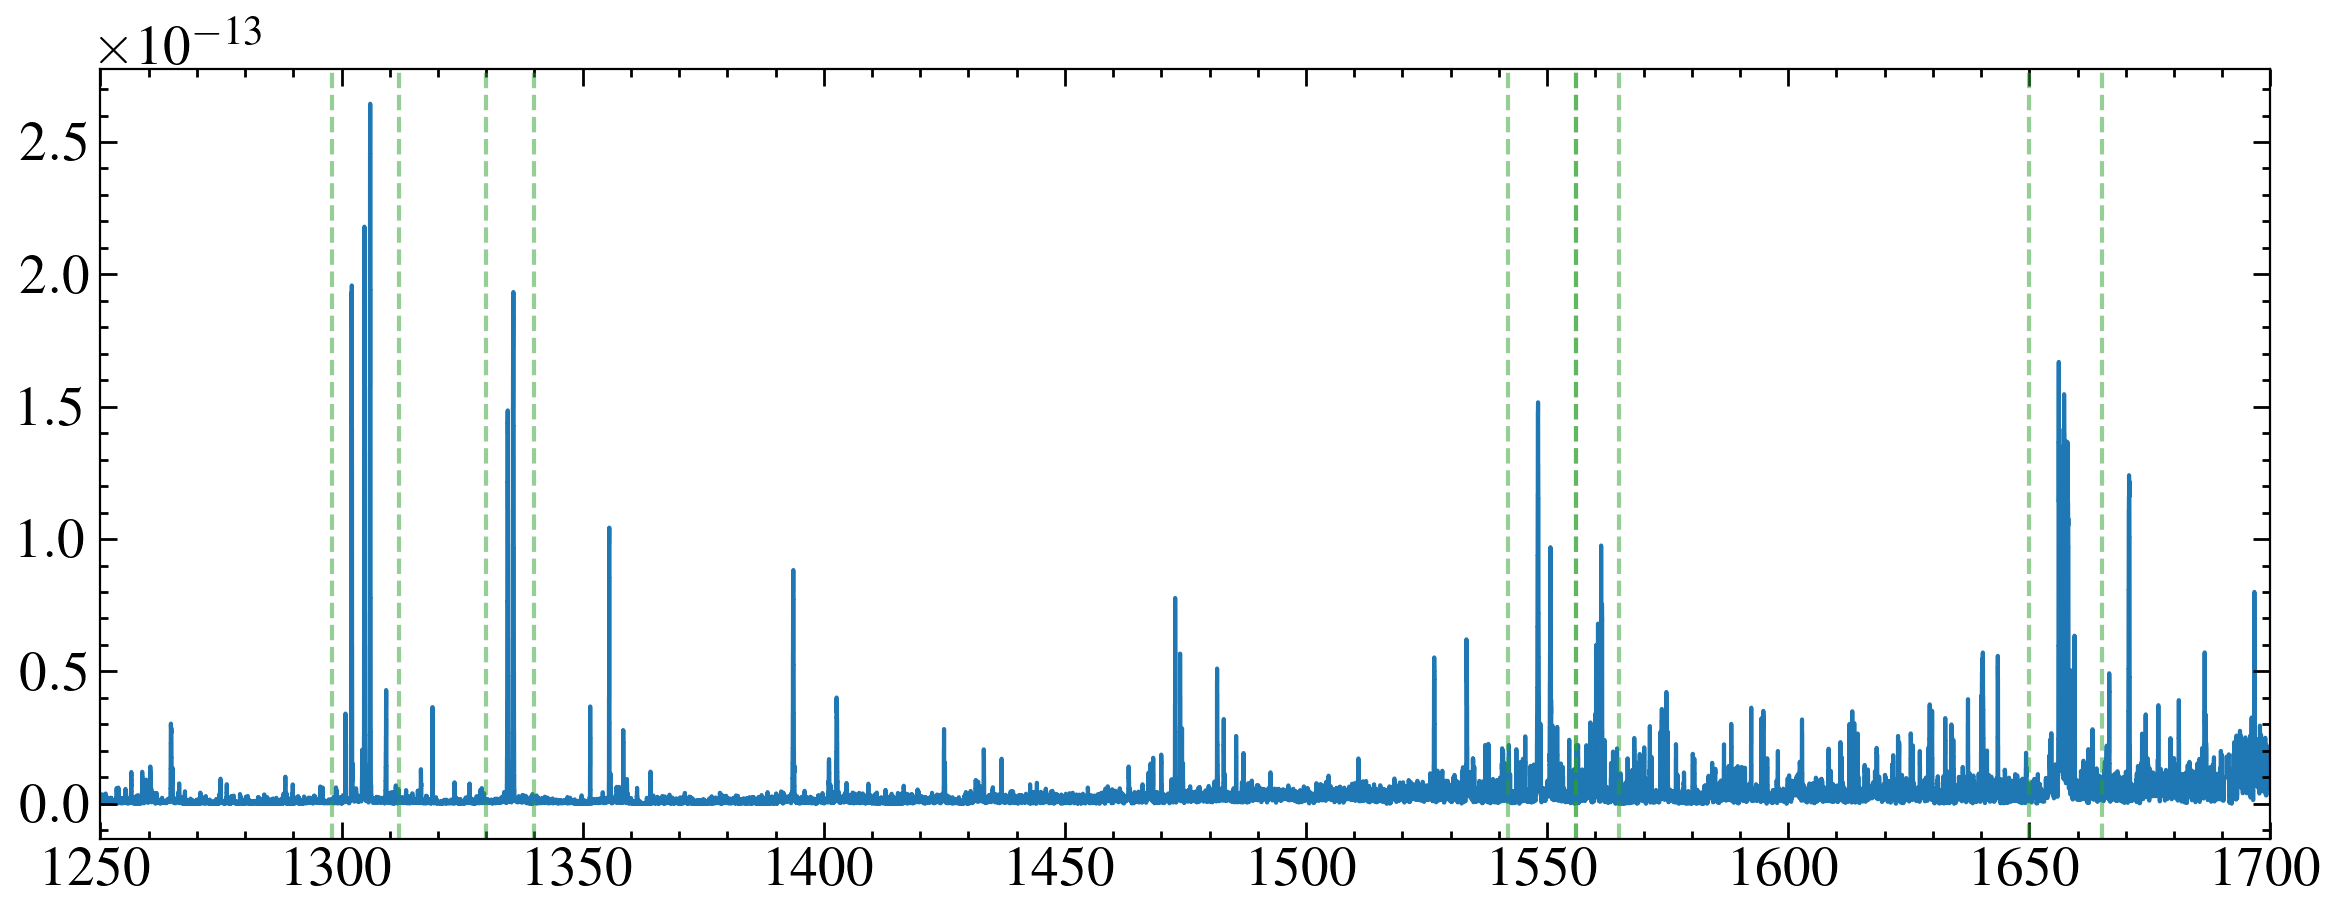

In [72]:
pmask = (pw > 1000) & (pw < 2000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 500)

line_regions = [[1298, 1312], [1330, 1340], [1542,1556], [1556,1565], [1650, 1665]]


fig, ax = plt.subplots()

# ax.step(w_lw[lmask], f_lw[lmask], where='mid')
# ax.step(w_sw[smask], f_sw[smask], where='mid')
# ax.step(w_sw[smask], e_sw[smask], where='mid')

lymask = (w_fuv < 1200) | ((w_fuv > 1230))
f_fuvi = convolve(f_fuv,Box1DKernel(2))

ax.step(w_fuv[lymask], f_fuvi[lymask], where='mid', zorder=-1)


# wfi, ffi = pp.smear(w_fuv, f_fuv, 300)
# lymask = (wfi < 1200) | ((wfi > 1230))
# ax.step(wfi[lymask], ffi[lymask], where='mid', zorder=-1)
# ax.step(wfi[lymask], ffi[lymask]*3, where='mid', ls='--')
# ax.step(pwi, pfi)uide star acquisition failed. Actual guide mode is gyro. COS internal shutter closed. No counts in exposure. Actual exposure time significantly less than planned exposure.

[ax.axvline(lines[0], ls='--', c='C2', alpha=0.5) for lines in line_regions]
[ax.axvline(lines[1], ls='--', c='C2', alpha=0.5) for lines in line_regions]

line_w = []
iue_flux = []
stis_flux = []

for lines in line_regions:
    line_w.append(np.mean(lines))
#     imask = (w_sw > lines[0]) & (w_sw <= lines[1])
    stmask = (w_fuv > lines[0]) & (w_fuv <= lines[1])
#     iue_flux.append(np.trapz(f_sw[imask], w_sw[imask]))
    stis_flux.append(np.trapz(f_fuv[stmask], w_fuv[stmask]))
    print(lines, np.trapz(f_fuv[stmask], w_fuv[stmask]))
    
    

# ax.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# ax.plot(lyaw, lyamod)

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(1250, 1700)

In [36]:

# from astropy.modeling import models, fitting

# ratio = np.array(iue_flux)/np.array(stis_flux)
# plt.scatter(line_w, ratio)
# plt.axhline(np.mean(ratio), ls='--')
# # plt.axhline(np.median(ratio), ls='-.')
# print(np.mean(ratio), np.std(ratio))

# plt.scatter(2800, 1/1.27)

# alines = np.append(line_w, 2800)
# aratios = np.append(ratio, 1/1.27)


# mod = models.Polynomial1D(degree=2)
# fitter= fitting.LinearLSQFitter() 
# modfit = fitter(mod, alines, aratios)
# wfit = np.linspace(1300, 3000, 100)
# plt.plot(wfit, modfit(wfit))

# modfit2 = fitter(mod, line_w, ratio)
# plt.plot(wfit, modfit2(wfit))

20230520 compare with Tom Ayre's STIS spectrum, which adjusts for aperture. Alternatively, could be scattered light in IUE

In [37]:
# fig, ax= plt.subplots()

# ax.step(w_fuv[lymask], f_fuv[lymask], where='mid', alpha=0.5)

# tdata = fits.getdata('{}h_hd10700_e140m-1425_020x020_51757_spc.fits'.format(path), 1)[0]
# tw, tf, te = tdata['WAVE'], tdata['FLUX'], tdata['ERROR']
# tmask = (tw > 1160) & (tw < 1200) | (tw > 1230) 

# ax.step(tw[tmask], tf[tmask], where='mid', alpha =0.5, zorder=-1)
# ax.set_ylim(-0.1e-13, 1e-13)
# ax.set_xlim(1460, 1490)

Not significantly higher. Check the NUV, maybe scale the IUE data to the FUV lines. Tom says the problem is IUE

In [38]:
# plt.step(w_sw[smask], f_sw[smask], where='mid')


# plt.step(wfi[lymask], ffi[lymask], where='mid', zorder=100, c='C1', lw=2, label = 'STIS to R(IUE) ')

# scale = 1/modfit(w_sw[smask])

# plt.step(w_sw[smask], f_sw[smask]*scale, where='mid', c='C2')

# scale = 1/modfit2(w_sw[smask])

# plt.step(w_sw[smask], f_sw[smask]*scale, where='mid', c='C3')

# plt.step(w_lw, f_lw, where='mid')
# # plt.xlim(1250, 2200)
# plt.yscale('log')

https://arxiv.org/pdf/2307.10394.pdf has new stellar parameters

In [39]:
#params from TICv8 via exoplanet archive
import prepare_phoenix_svo as pp
importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.69
teff = 5320
teff_e = 40

radius = 0.793
distance = 3.652

save_path = 'models/'
star = 'Tau_Ceti_newpar'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.48
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/Tau_Ceti_newpar_phoenix_interpolated.ecsv')
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [40]:
# pdata = Table.read('models/Tau_Ceti_phoenix_interpolated.ecsv')
# pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
# normfac = pdata.meta['NORMFAC']
# pf, pe = pf*normfac, pe*normfac
# pdata1 = Table.read('models/Tau_Ceti_newpar_phoenix_interpolated.ecsv')
# pw1, pf1, pe1 = pdata1['WAVELENGTH'], pdata1['FLUX'], pdata1['ERROR']
# normfac1 = pdata.meta['NORMFAC']
# pf1, pe1 = pf1*normfac1, pe1*normfac1

In [41]:
# fig, axes = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)
# axes[0].plot(pw, pf, alpha = 1)
# axes[0].plot(pw1, pf1, alpha = 1)
# # axes[0].set_xscale('log')
# axes[0].set_yscale('log')
# axes[0].set_xlim(1500, 10000)
# axes[0].set_ylim(1e-20, 1e-9)

# ratio = pf/pf1
# axes[1].plot(pw, ratio, c='C3')
# axes[1].set_ylim(0.8, 1.5)
# axes[1].axhline(1.0, ls='--', c='C2')

# print(np.trapz(pf[pw >2000], pw[pw >2000])/np.trapz(pf1[pw >2000], pw1[pw >2000]))

Putting together SED: Can I ditch IUE all together and use the PHX model?

(1e-16, 1.059333739530132e-10)

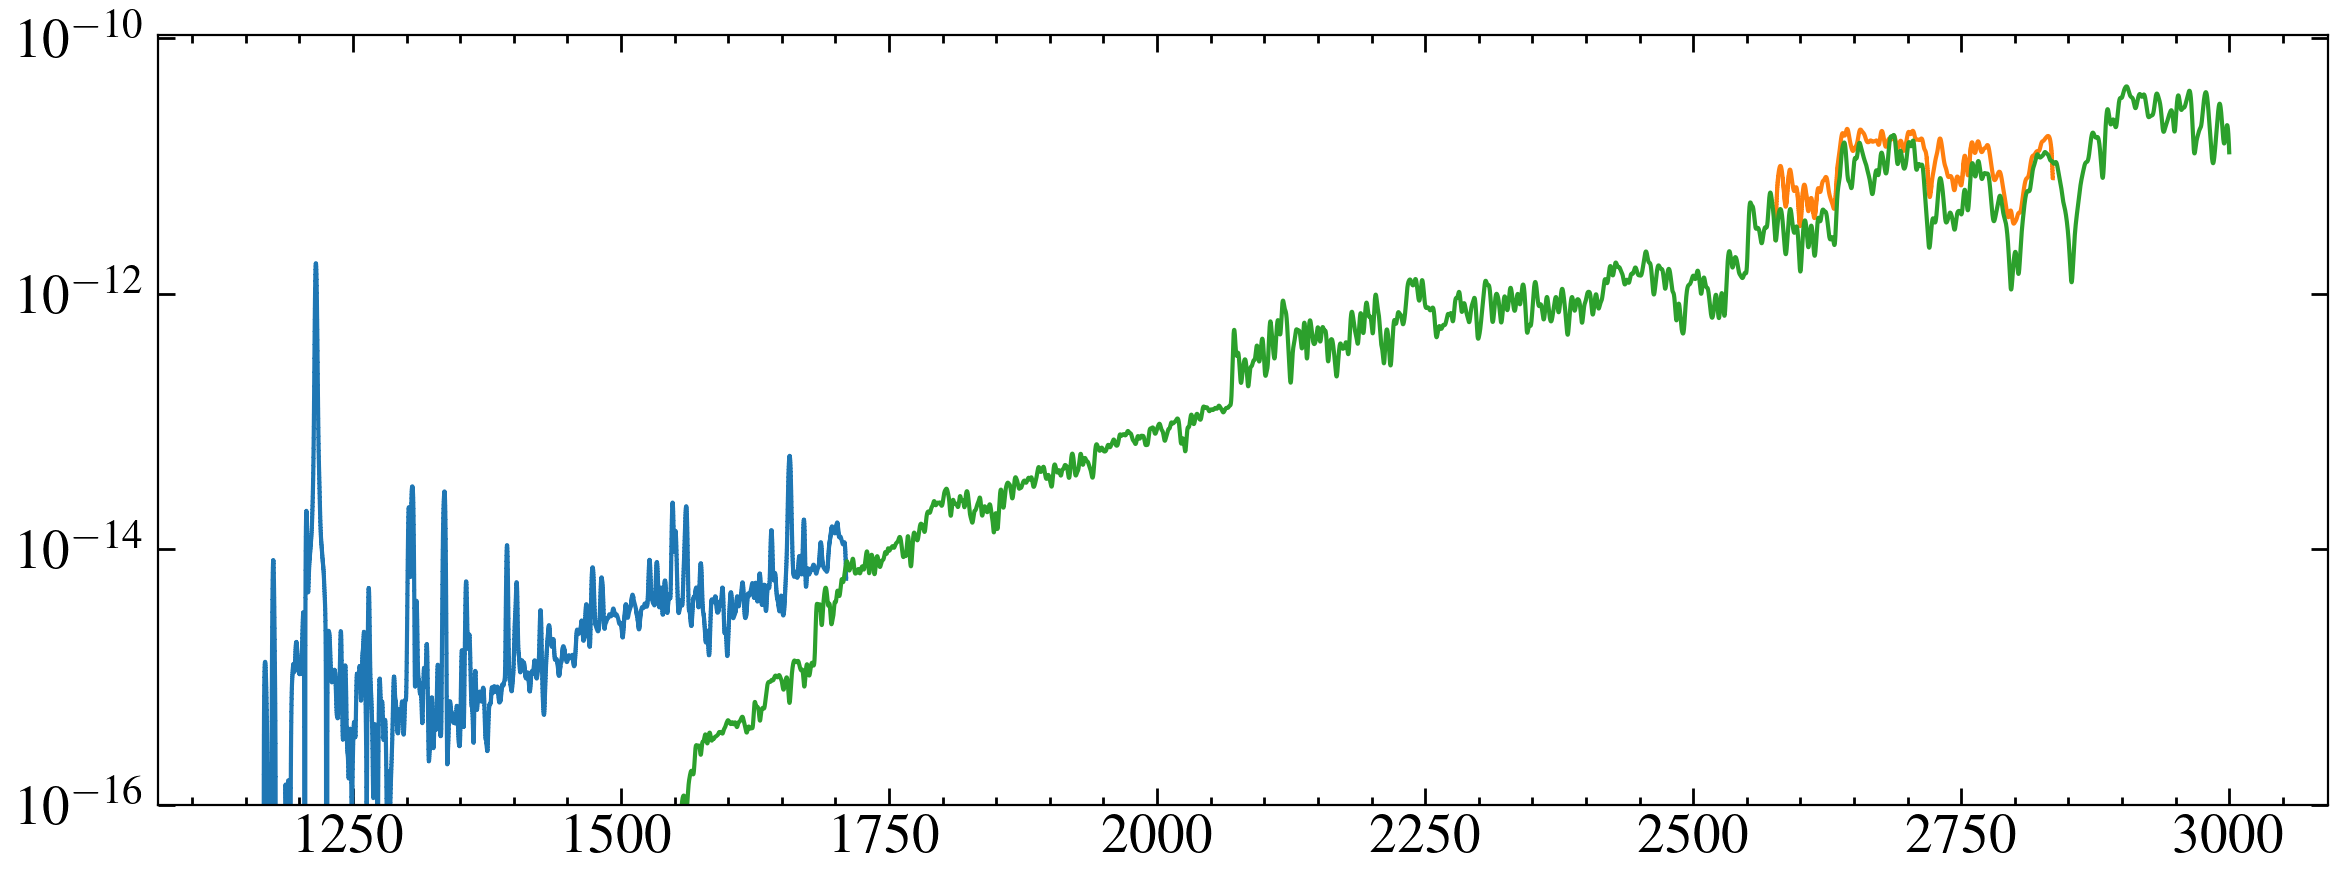

In [42]:
hlsp_x1ds = glob.glob('draft_hlsp/tau_ceti/*stis*.fits')

for x in hlsp_x1ds:
    data = fits.getdata(x, 1)
    grating = fits.getheader(x, 0)['GRATING']
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    if grating == 'E230H':
        wi, fi = pp.smear(w, f, 2000)
        
    else:
        mask = w > 1160
#         wi, fi = w[mask], f[mask]
        wi, fi = pp.smear(w[mask], f[mask], 2000)
        
    plt.step(wi, fi)
pmask = (pw > 1500) & (pw < 3000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 2000)

plt.plot(pwi, pfi)

plt.yscale('log')

plt.ylim(1e-16)    
    

Good enough, makes things easier.

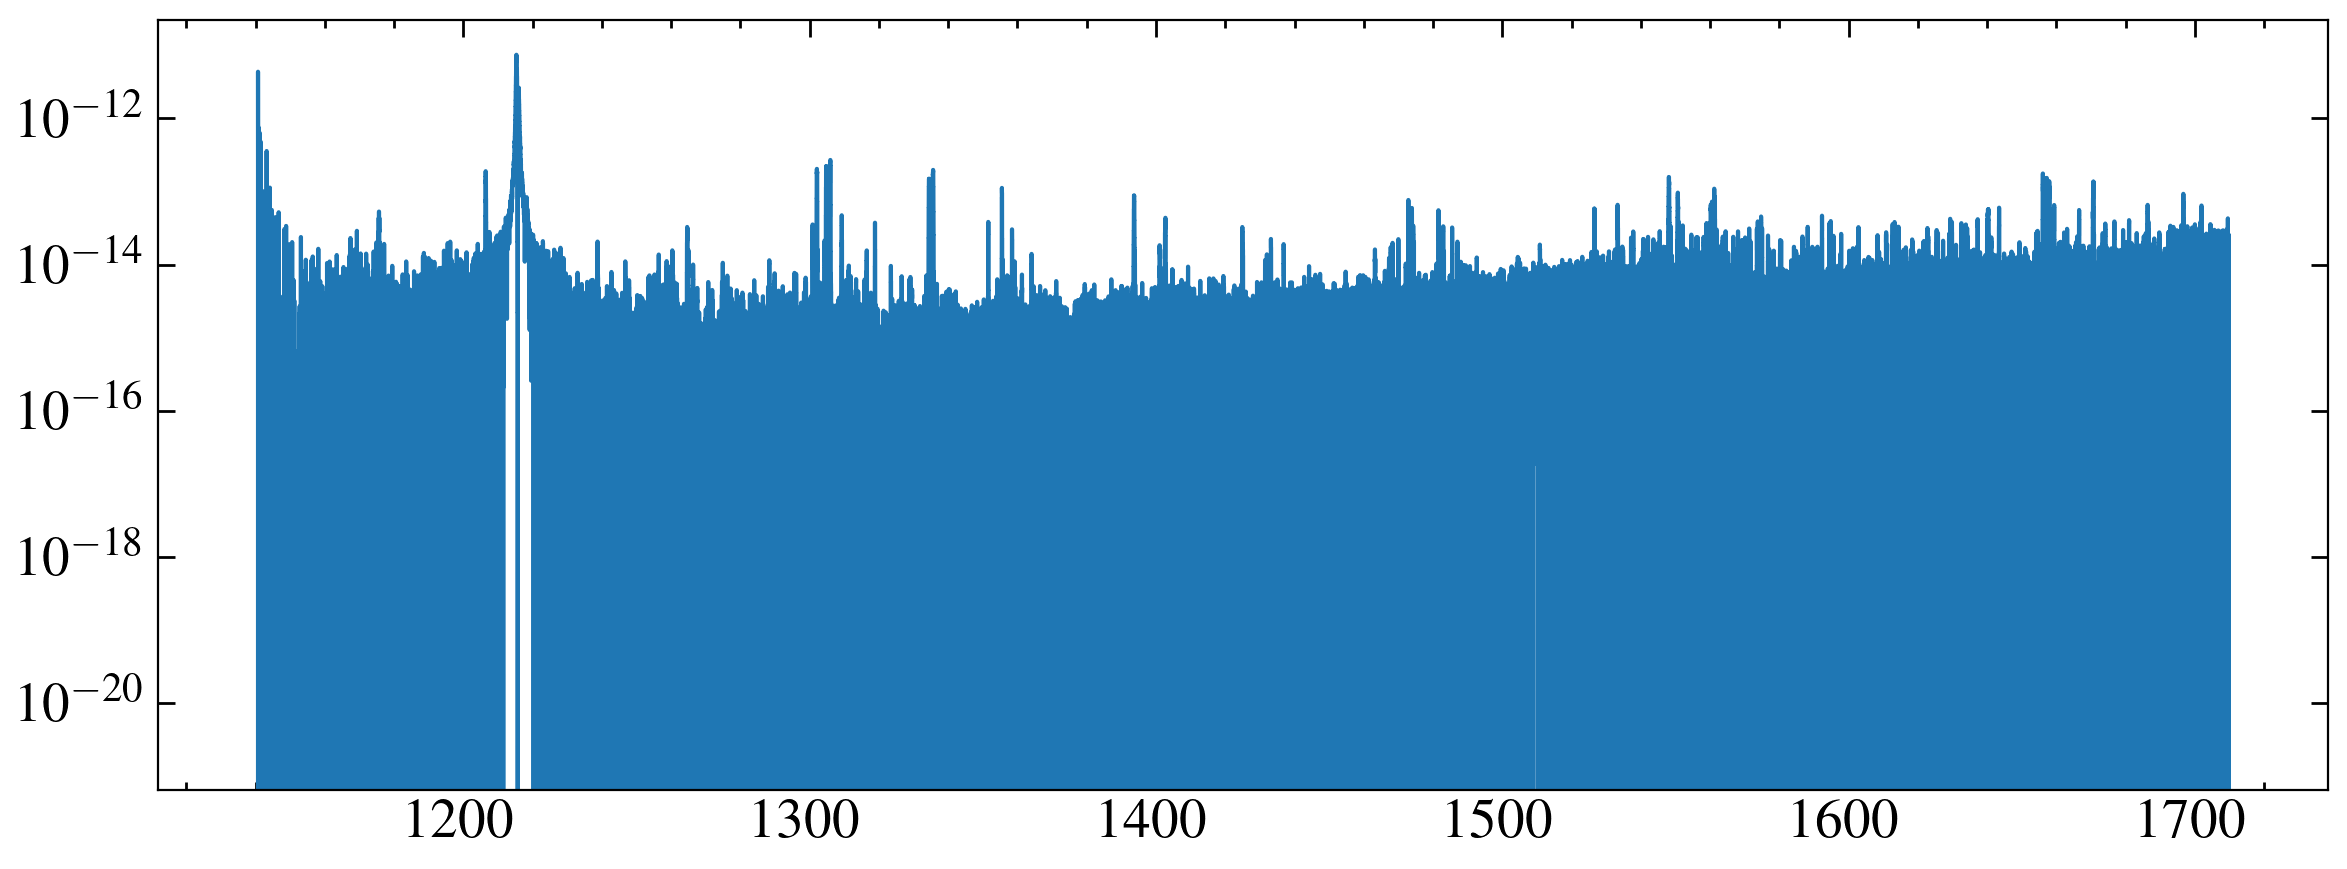

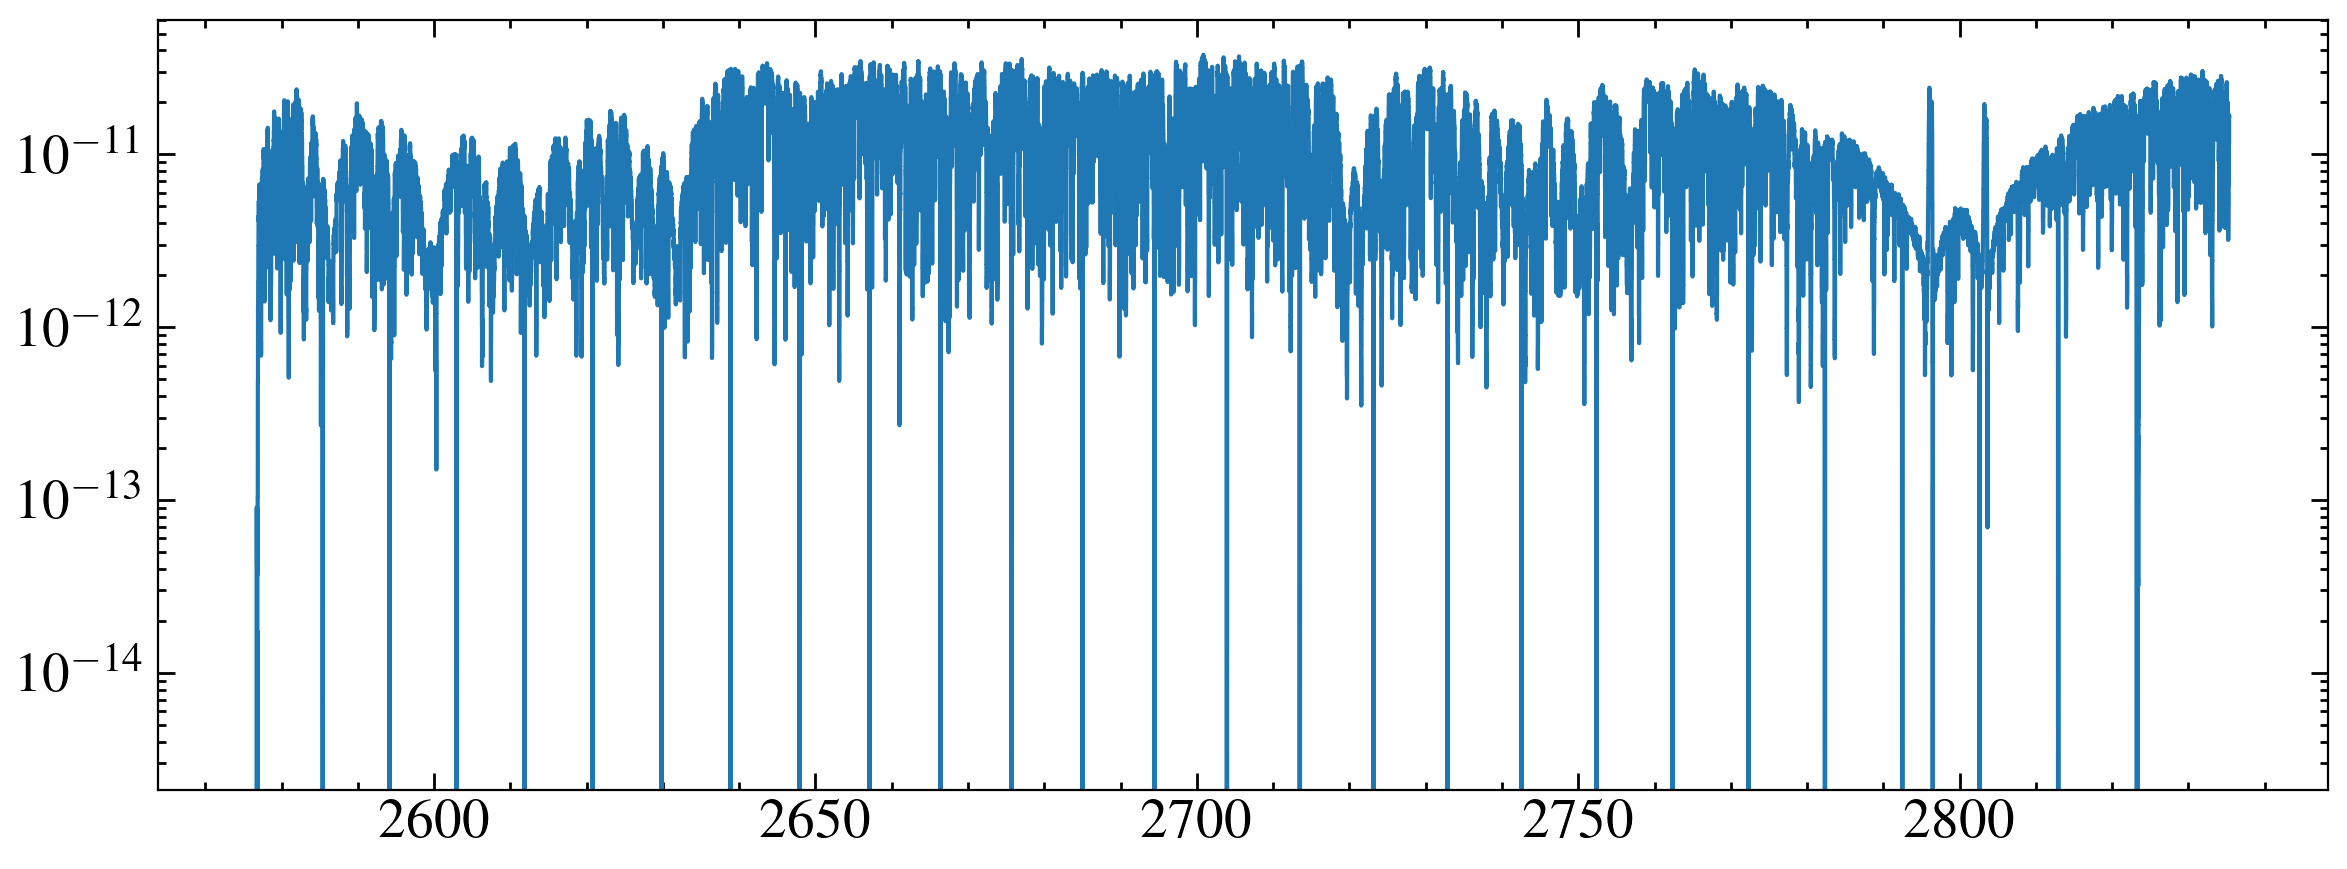

In [43]:
for x in hlsp_x1ds:
    data = fits.getdata(x, 1)
    grating = fits.getheader(x, 0)['GRATING']
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    plt.step(w, f)
    plt.yscale('log')
    plt.show()

In [44]:
import prepare_model


In [45]:
savepath

'draft_hlsp/tau_ceti/'

In [46]:
hdr = fits.getheader(hlsp_x1ds[1])
sed_data = Table(meta=hdr)
sed_data.meta['PR_INV_L'] = 'Youngblood'
sed_data.meta['PR_INV_F'] = 'Allison'
sed_data.meta

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'HST     '                                                            
INSTRUME= 'STIS    '                                                            
GRATING = 'E230H   '                                                            
APERTURE= '0.2X0.2 '                                                            
TARGNAME= 'Tau_Ceti'                                                            
RA_TARG =        26.0057610635                                                  
DEC_TARG=      -15.93211025613                                                  
PROPOSID=                16225                                                  
HLSPNAME= 'MUSCLES Extension

In [47]:
#phx
# prepare_model.make_model_spectrum('models/Tau_Ceti_newpar_phoenix_interpolated.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')


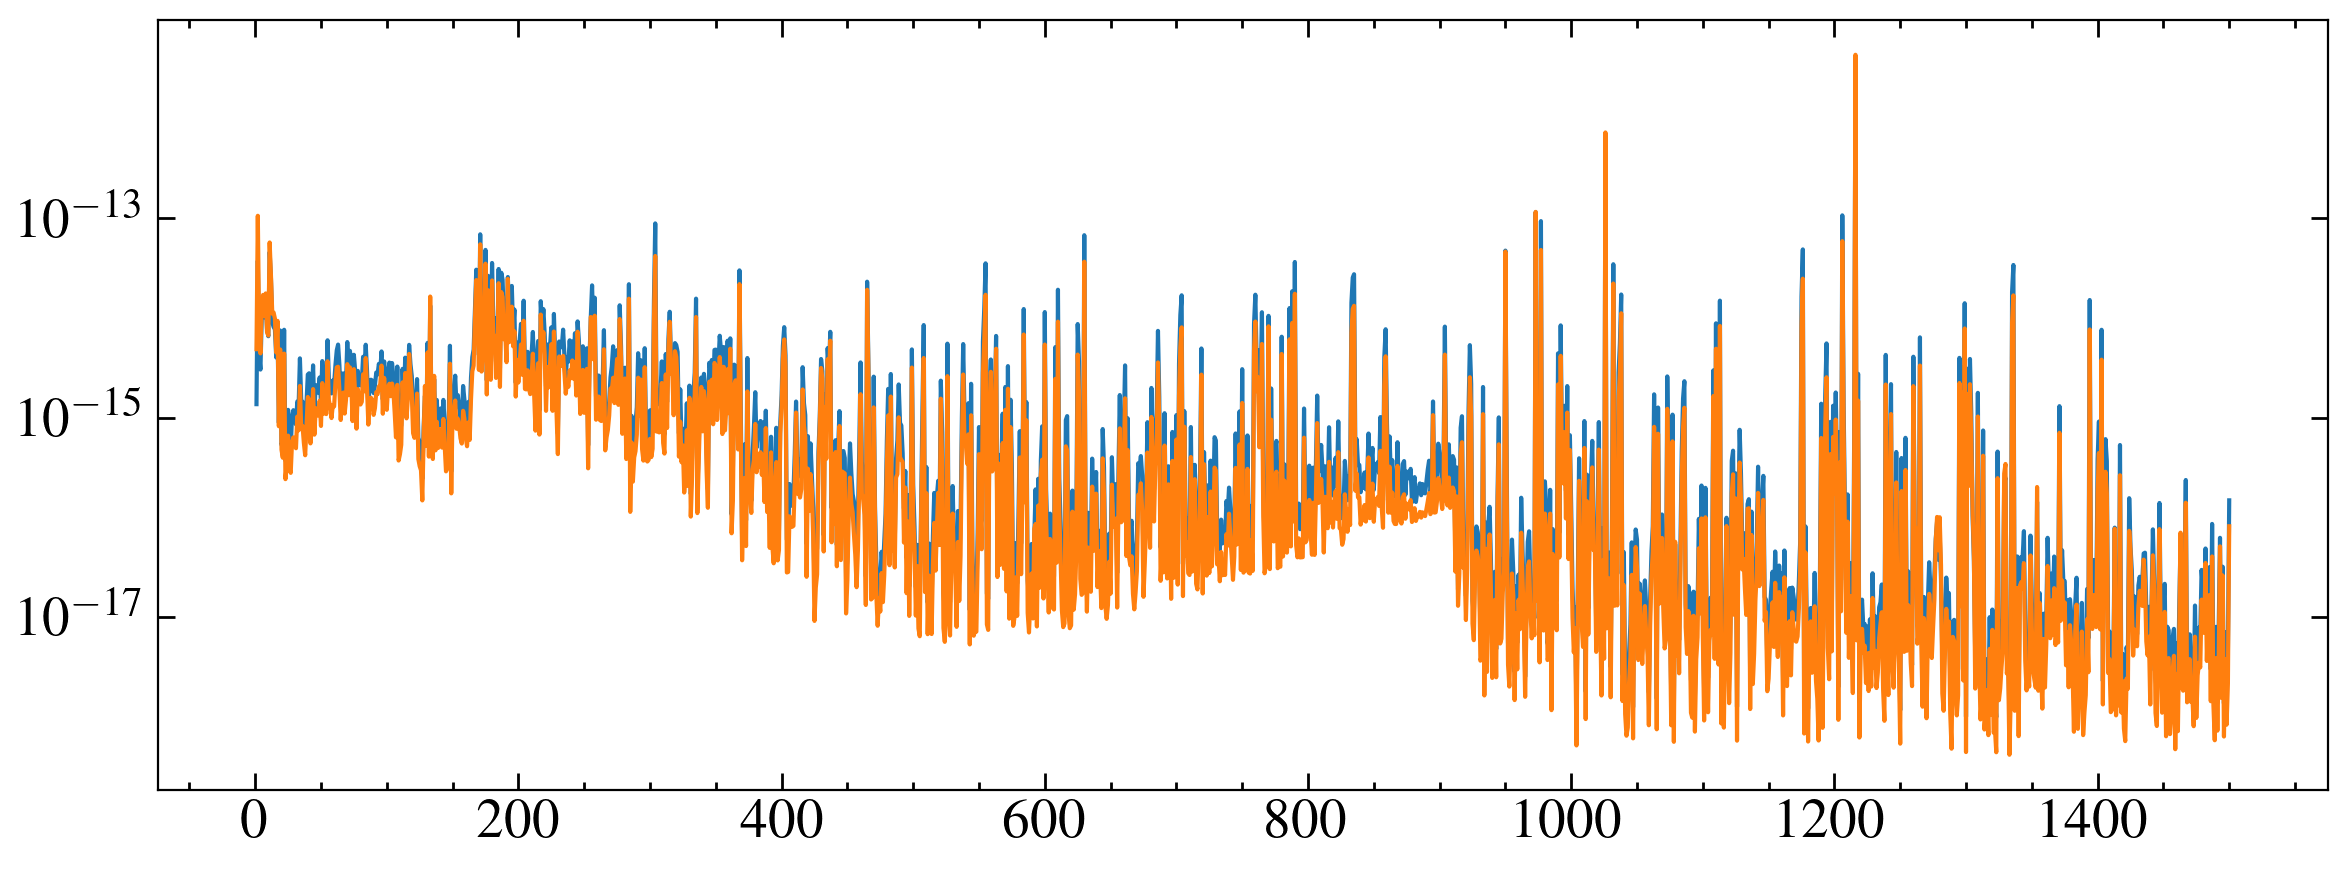

In [48]:
#dem

dempath = '/media/david/2tb_ext_hd/hddata/meats/dems/tau_ceti/spectrum_tau_ceti_p17.fits'
dem = fits.getdata(dempath, 1)

dw, df= dem['Wavelength'], dem['Flux_density']
eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']


mean_e = np.mean([eu, el], axis=0)
# plt.plot(dw, mean_e)
# plt.yscale('log')

log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

plt.plot(dw, df)
plt.plot(dw, log_mean_e)
# plt.plot(dw, mean_e)

plt.yscale('log')

demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
demtab.write('models/tau_ceti_dem.ecsv', overwrite=True)
# prepare_model.make_model_spectrum('models/tau_ceti_dem.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='dem')


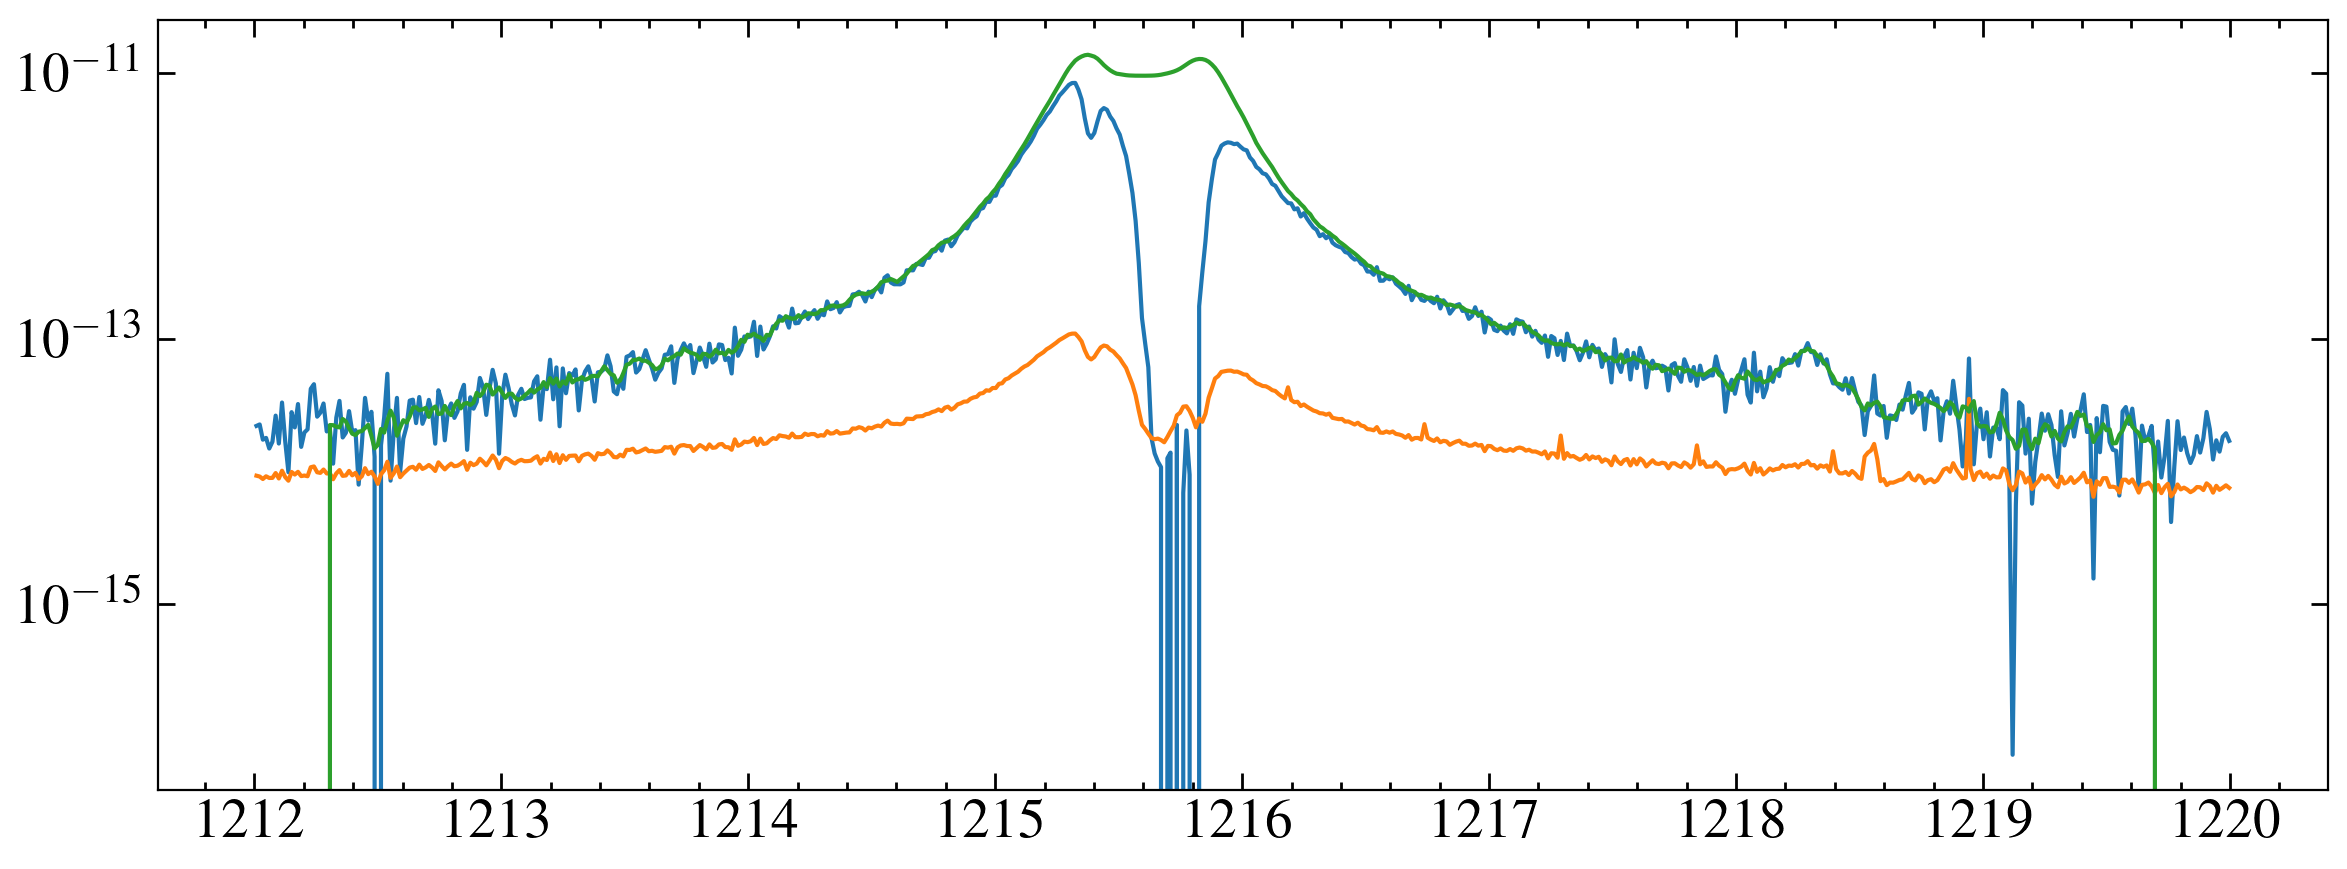

Spectrum saved as hlsp_muscles_model_lya_tau_ceti_na_v1_component-spec.fits


In [49]:
lyapath =  '/media/david/2tb_ext_hd/hddata/meats/lya/tau_ceti/taucet_lya.txt'
lyaw, lyaf, lyae, lyamod = np.loadtxt(lyapath, unpack =True)
plt.plot(lyaw, lyaf)
plt.plot(lyaw, lyae)
plt.plot(lyaw, lyamod)
plt.yscale('log')

plt.show()
lyamask = (lyamod > 0.0)
# plt.plot(lyaw[lyamask], (lyaf/lyamod)[lyamask])
# print(np.max(lyaf))

#assuming a 10% uncertainty on each resel of the Lya model


savdat = Table([lyaw[lyamask], lyamod[lyamask], lyamod[lyamask]*0.1], names=['WAVELENGTH', 'FLUX', 'ERROR'])

savdat.write('models/tau_ceti_lya.ecsv', format='ascii.ecsv', overwrite=True)
prepare_model.make_model_spectrum('models/tau_ceti_lya.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='LYA')

In [50]:
import prepare_xmm

In [51]:
xpath = '/media/david/2tb_ext_hd/hddata/meats/xmm/tau_ceti/tau_ceti.fits'

xfits = fits.open(xpath)
hdr = xfits[0].header
data = xfits[1].data
print(data[0:1])
hdr

[(9.778096, 1.3065686, -3.2664072e-08, 4.378079e-08, -6.6810696e-17, 8.95487e-17, 2.09873e-19, 1., -6.6810696e-17, 8.95487e-17)]


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'tau Cet '                                                            
HIERARCH Instrument = 'EPIC    '                                                

In [52]:
hdr.append(('mos1_FILTER', 'Thick'))
hdr.append(('mos2_FILTER', 'Thick'))
hdr.append(('pn_FILTER', 'Thick'))
hdr.append(('pn_DURATION', 15413))
hdr.append(('pn_DATE-OBS', '2011-12-20T23:39:40'))
hdr.append(('pn_DATE-END','2011-12-21T03:56:33' ))
hdr.append(('OBS_ID', '0670380501'))
hdr['TARGET'] = 'Tau_Ceti'
xfits[1].data = data[3:] #cutting off the negative flux bins at the begining
print(xfits[1].data[0:1]) 
hdr

[(20.070301, 0.16346022, 5.065393e-07, 6.230837e-07, 5.047651e-16, 6.209012e-16, 2.946113e-16, 0.94189304, 5.359049e-16, 6.592056e-16)]


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'Tau_Ceti'                                                            
HIERARCH Instrument = 'EPIC    '                                                
HIERARCH mos1_FILTER = 'Thick   '                                               
HIERARCH mos2_FILTER = 'Thick   '                                               
HIERARCH pn_FILTER = 'Thick   '                                                 
HIERARCH pn_DURATION = 15413                                                    
HIERARCH pn_DATE-OBS = '2011-12-20T23:39:40'                                    
HIERARCH pn_DATE-END = '2011-12-21T03:56:33'                                    
OBS_ID  = '0670380501'      

In [53]:
xfits.writeto('/media/david/2tb_ext_hd/hddata/meats/xmm/tau_ceti/tau_ceti_corr_djw.fits', overwrite=True)

In [54]:
xmm_path = '/media/david/2tb_ext_hd/hddata/meats/xmm/tau_ceti/tau_ceti_corr_djw.fits'

hlsp = dict(Table.read('meats_hlsp_info.csv'))
# hlsp = np.genfromtxt('meats_hlsp_info.csv', delimiter=',', dtype=None, names=True)
# xmm_path = xpath
version = 1

prepare_xmm.make_xmm_spectra(xmm_path, savepath, version, hlsp, apec_repo='models/', make_apec=True, save_ecsv=False, save_fits=True)

Spectrum saved as hlsp_muscles_xmm_epic_tau_ceti_na_v1_component-spec.fits


5.047651e-16

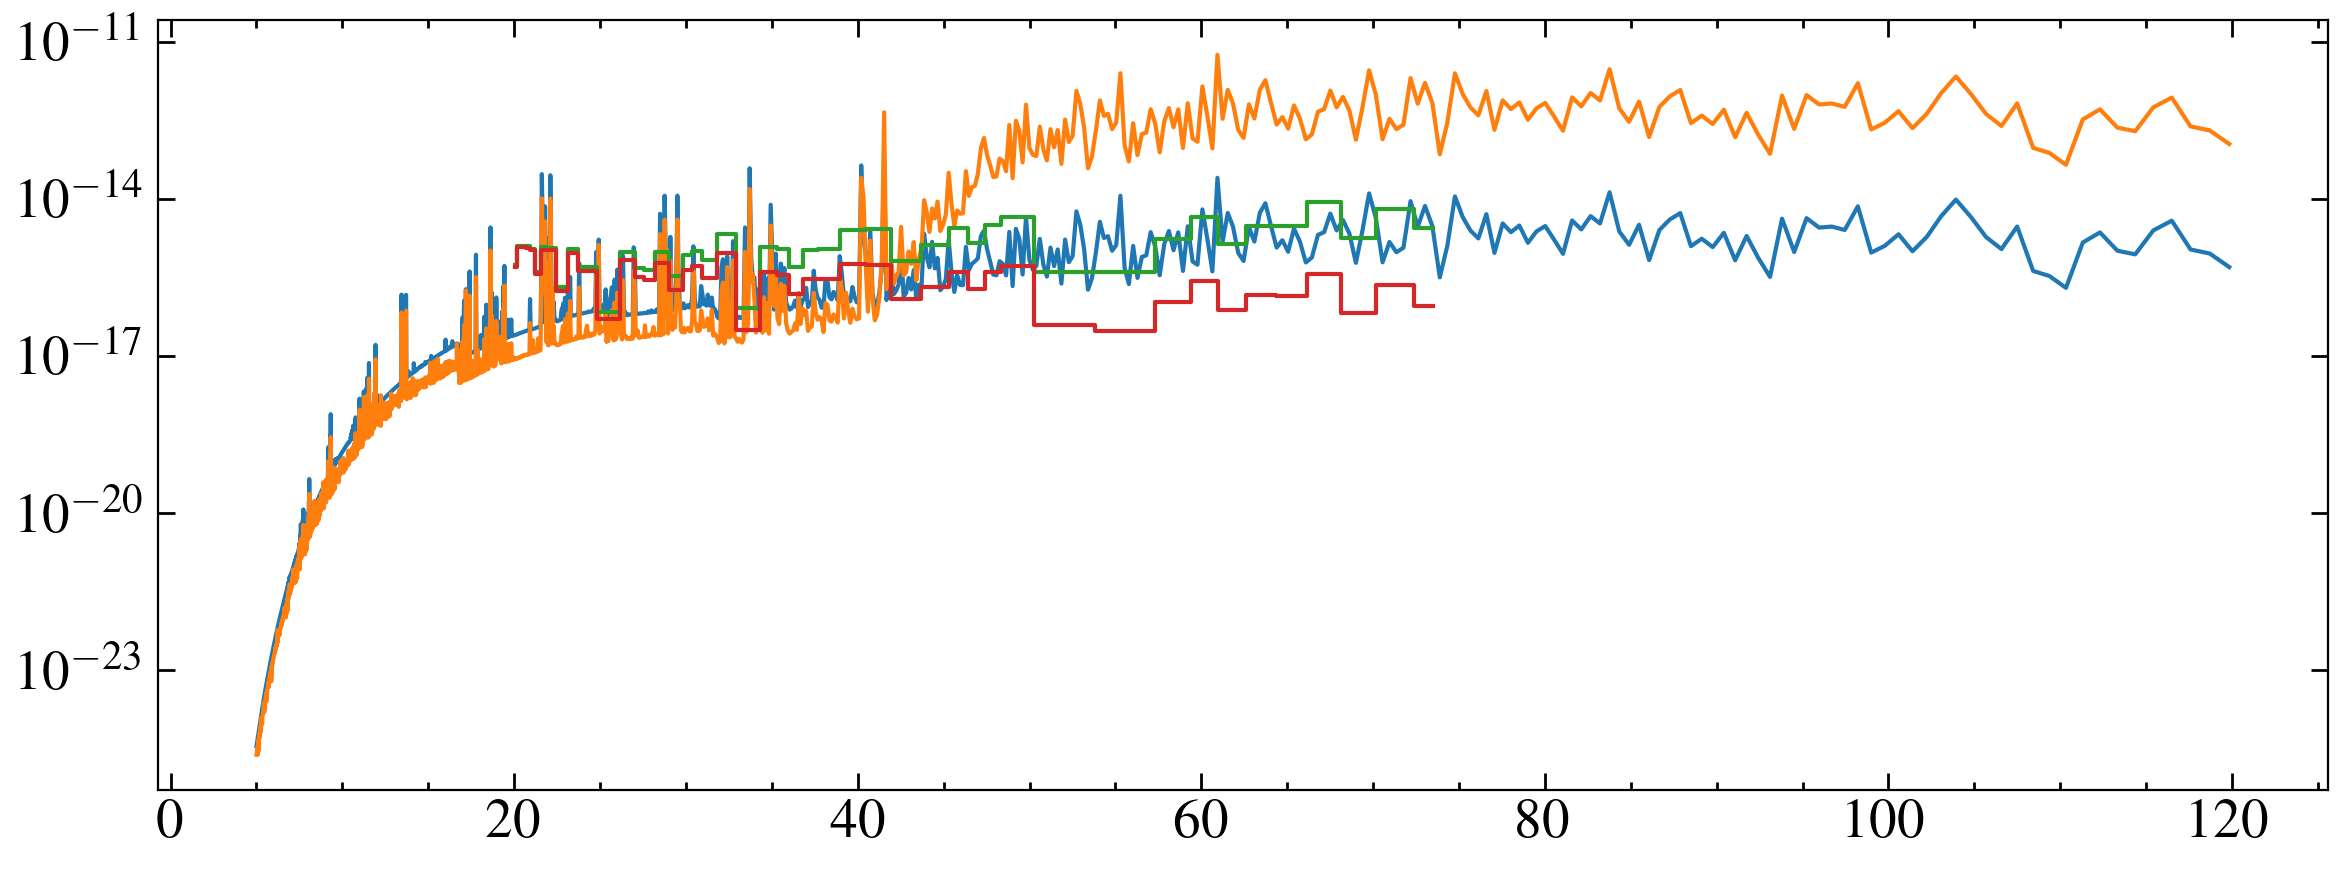

In [55]:
xray = Table.read('models/tau_ceti_apec.txt', format='ascii.basic')
# plt.plot(xray['WAVELENGTH'], xray['FLUX'])
plt.yscale('log')

xray = Table.read('models/Tau_Ceti_apec_errs.ecsv')
plt.plot(xray['WAVELENGTH'], xray['FLUX'])
plt.plot(xray['WAVELENGTH'], xray['ERROR'])
# prepare_model.make_model_spectrum('models/WASP-121_apec_errs.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='apec')

xdata = xfits[1].data
plt.step(xdata['Wave'], xdata['CFLux'], where='mid')
plt.step(xdata['Wave'], xdata['FLux'], where='mid')
xdata['FLUX'][0]

draft_hlsp/tau_ceti/hlsp_muscles_model_lya_tau_ceti_na_v1_component-spec.fits 1.0
draft_hlsp/tau_ceti/hlsp_muscles_model_dem_tau_ceti_na_v1_component-spec.fits 1
draft_hlsp/tau_ceti/hlsp_muscles_model_apec_tau_ceti_na_v1_component-spec.fits 1.0
draft_hlsp/tau_ceti/hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits 1.0
draft_hlsp/tau_ceti/hlsp_muscles_model_phx_tau_ceti_na_v1_component-spec.fits 2.396777688346e-17
draft_hlsp/tau_ceti/hlsp_muscles_xmm_epic_tau_ceti_na_v1_component-spec.fits 1.0
draft_hlsp/tau_ceti/hlsp_muscles_hst_stis_tau_ceti_e230h_v1_component-spec.fits 1.0


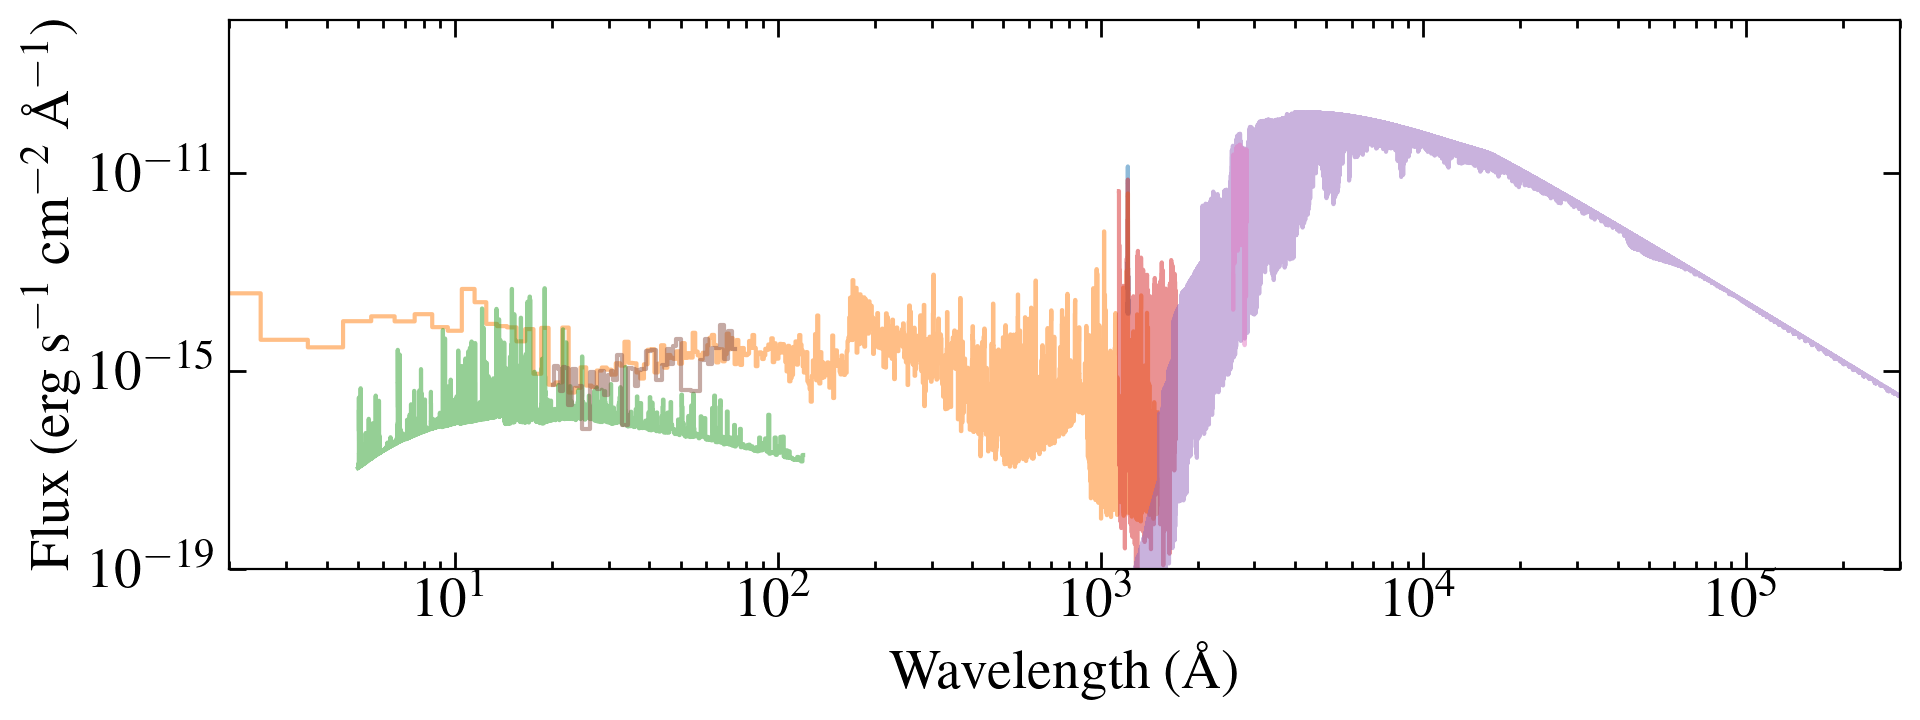

In [56]:
fig, ax=plt.subplots(figsize=(10,4))

all_hlsp = glob.glob('draft_hlsp/tau_ceti/*v1*.fits')

for x in all_hlsp:
    if 'multi_multi' not in x:
        data = fits.getdata(x, 1)
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        norm = fits.getheader(x, 0)['NORMFAC']
        print(x, norm)
        plt.step(w[f >0], f[f >0]*norm, where='mid', alpha=0.5)

    
plt.yscale('log')
plt.xscale('log')

plt.ylim(1e-19)
plt.xlim(2, 3e5)


plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
fig.tight_layout()

# fig.savefig('plots/wasp-121_all_components.pdf')

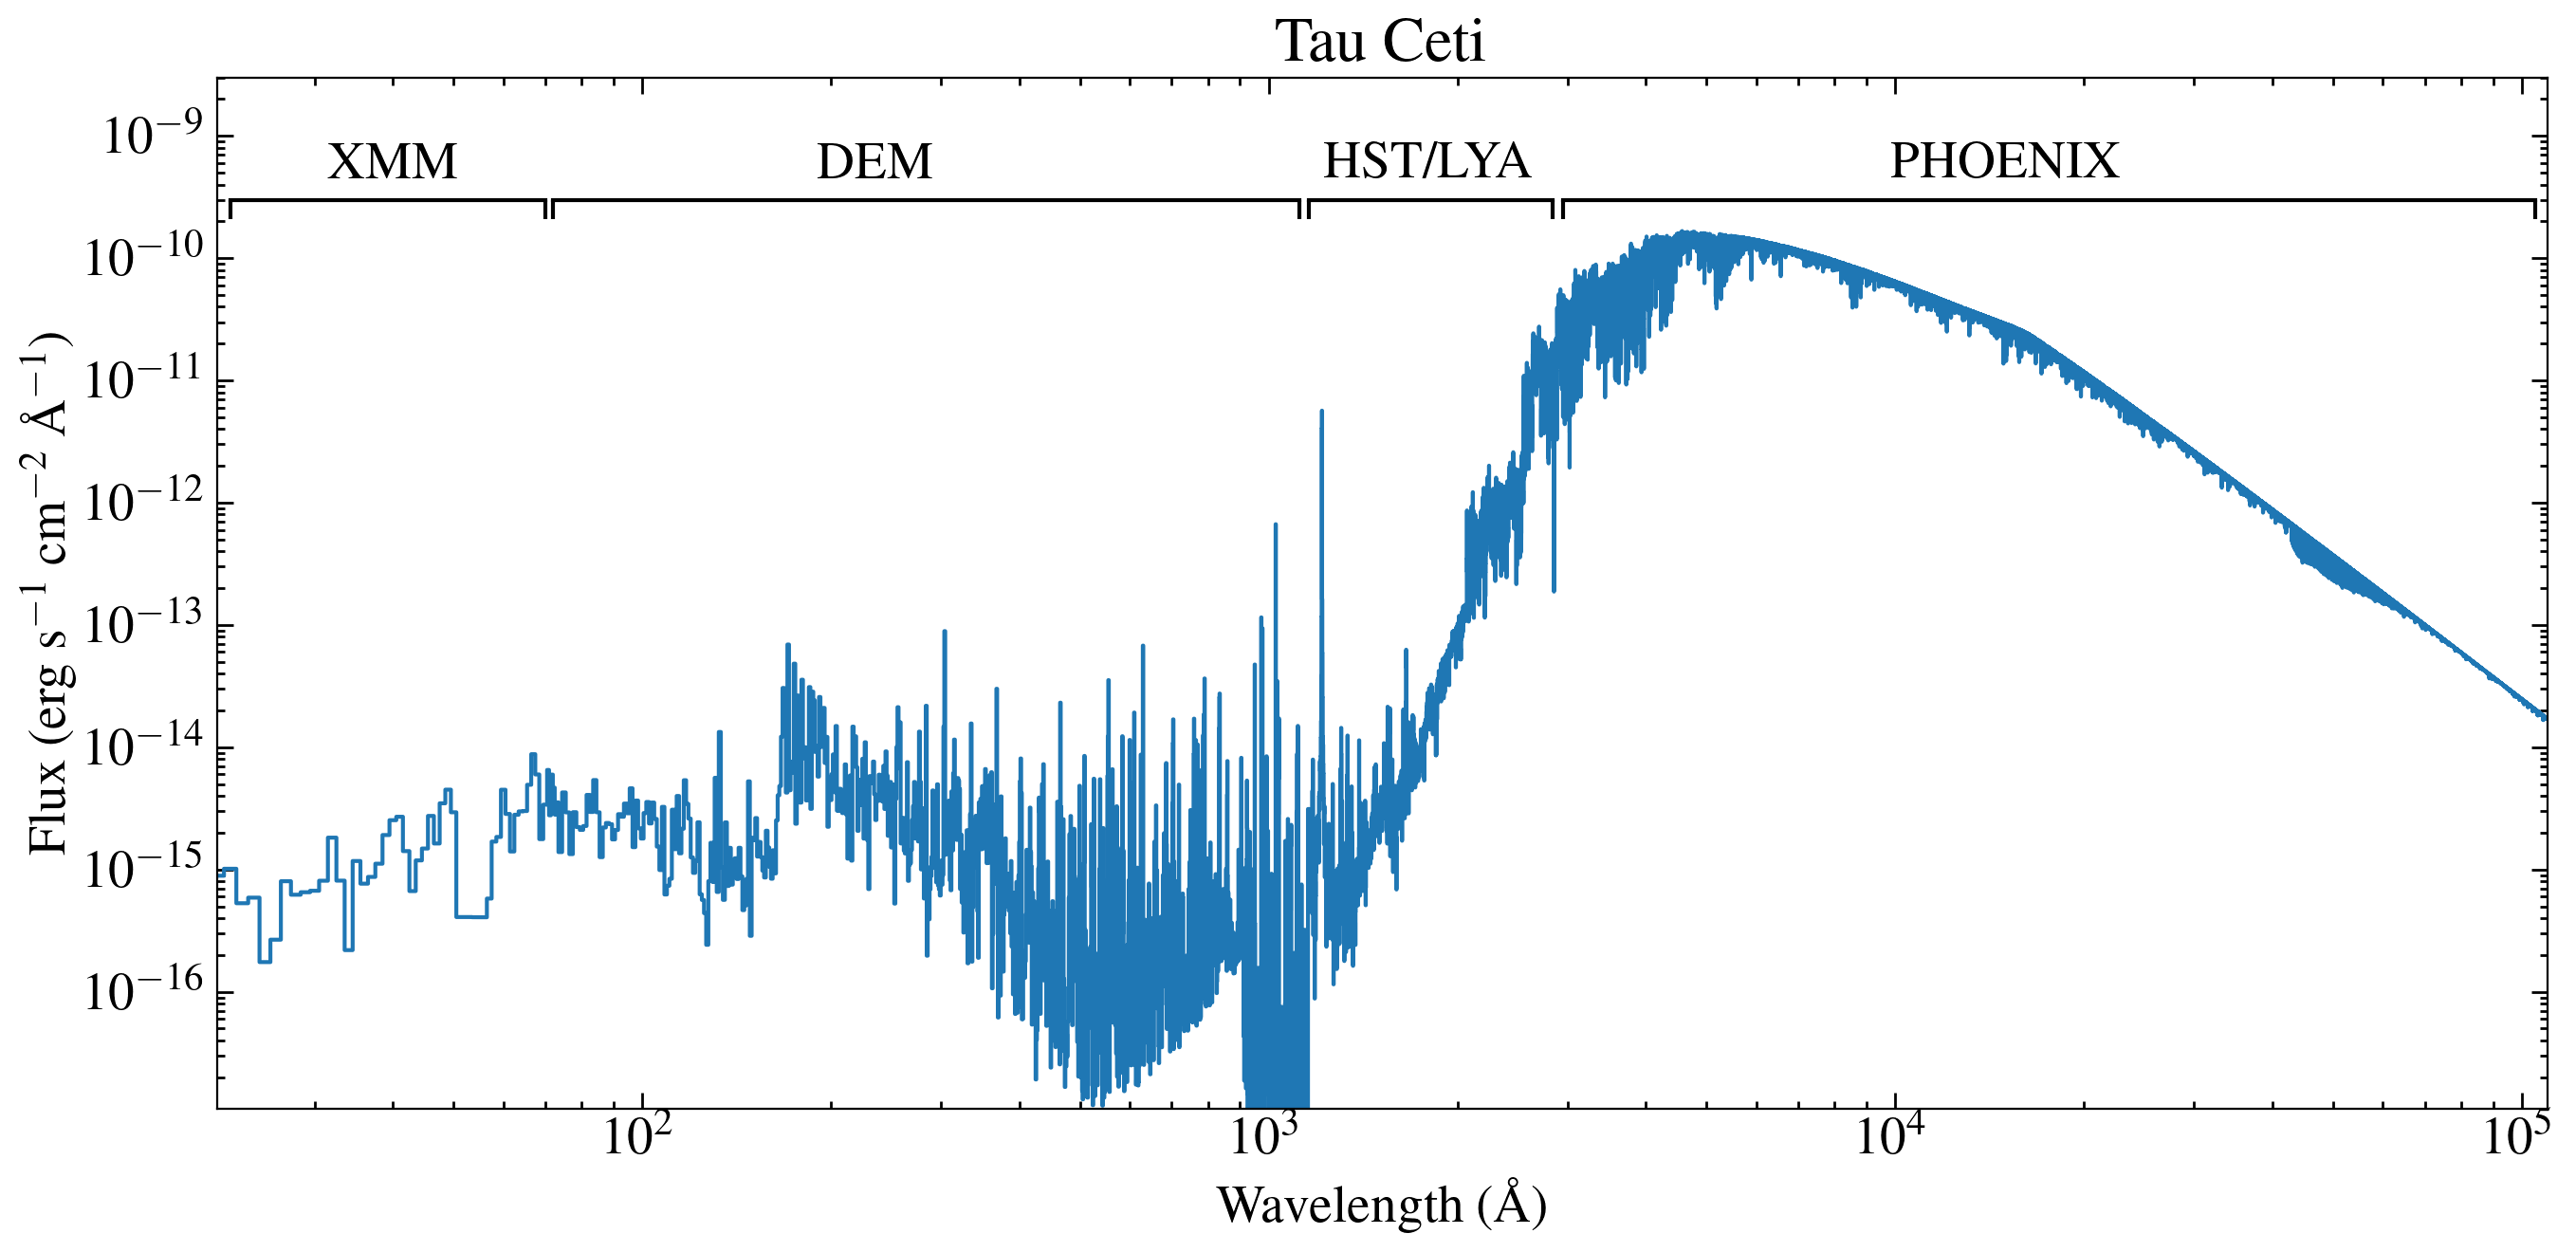

In [57]:
data = fits.getdata('draft_hlsp/tau_ceti/hlsp_muscles_multi_multi_tau_ceti_broadband_v1_adapt-const-res-sed.fits', 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

fig, ax = plt.subplots(figsize=(14, 7))
ax.step(w, f, where='mid')
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Wavelength (\AA)')
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_title('Tau Ceti')

labely = 3e-10
efac = 0.3
labelfac = 1.5

ax.errorbar(np.array([22,70]),np.array([labely, labely]), yerr= [[efac*labely,efac*labely],[0,0]], c ='k')
ax.annotate('XMM', (40, labelfac*labely),  ha='center')

ax.errorbar(np.array([72,1120]),np.array([labely, labely]), yerr= [[efac*labely,efac*labely],[0,0]], c ='k')
ax.annotate('DEM', (190, labelfac*labely))

ax.errorbar(np.array([1160, 2840]),np.array([labely, labely]), yerr= [[efac*labely,efac*labely],[0,0]], c ='k')
ax.annotate('HST/LYA', (1800, labelfac*labely), ha='center')

ax.errorbar(np.array([2950,  105000]),np.array([labely, labely]), yerr= [[efac*labely,efac*labely],[0,0]], c ='k')
ax.annotate('PHOENIX', (15000, labelfac*labely), ha='center')





ax.set_ylim(1.1e-17, 3e-9)
ax.set_xlim(21, 1.1e5)

fig.tight_layout()

plt.savefig('plots/tau_ceti_sed.pdf')

